# Exploring StackOverflow!


# Team members

- **Full name, Student ID, Institutional email, Github username**
- Mehrdad Hassanzadeh, 1961575, hassanzadeh.1961575@studenti.uniroma1. it, mehrdad-77
- Giulio D'Erasmo, 1859130, derasmo.1859130@studenti.uniroma1.it, giulio-derasmo
- Anthony Giusti, 1992018, giusti.1992108@studenti.uniroma1.it, AnthonyGiustiSapienza

# 0. Useful packages

In [1]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from itertools import combinations
import numpy as np
from collections import deque
from collections import Counter
from queue import Queue
import math
import copy
from tabulate import tabulate
%matplotlib inline
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from IPython.display import Image

# 1. Data

Here we should work with three datasets which are: 

1. **Answer_to_question.txt:** This dataset consists of three columns, 1. Source, 2. Distination and 3. Timestamp <br/>
This data set corresponds to the person who answered another person's question in the given timestamp. <br/><br/>
2. **Comment_to_question.txt:** This dataset consists of three columns, 1. Source, 2. Distination and 3. Timestamp <br/>
This data set corresponds to the person who put a comment on another person's question in the given timestamp.<br/><br/>
3. **Comment_to_answer.txt:** This dataset consists of three columns, 1. Source, 2. Distination and 3. Timestamp <br/>
This data set corresponds to the person who put a comment on another person's answer in the given timestamp. 


Here we are asked to merge these three datasets. Our approach for merging these is: <br/>
- We will consider a **directed graph**. We will have an edge from the source person to the distination person. <br/>
- Our directed graph will be also a **weighted graph**. We define the weight as the **number of the occurances of each of these relationships**.<br/>
- We are just considering the **relationship** between two person. We don't care about if the person put a comment on the question or answered the question. <br/>

* ***With the assumptions that we have here we can easily first merge all the three datasets together and after that we will try to build the graph.*** 

## 1.1 Merging the datasets

In [2]:
# Put the names of the header
Header = ['Source', 'Destination', 'Timestamp']

# Reading the first dataset
df1 = pd.read_csv('Answer_to_question', sep = ' ', header = None, names = Header)

# Reading the second dataset
df2 = pd.read_csv('Comment_on_answers', sep = ' ', header = None, names = Header)

# Reading the third dataset
df3 = pd.read_csv('Comment_on_question', sep = ' ', header = None, names = Header)

Here we will take a look at each of the datasets:

In [3]:
# Show the first dataset
print('\n\'Answer to question\' dataset:')
display(df1)


'Answer to question' dataset:


Source  Destination   Timestamp
0               9            8  1217567877
1               1            1  1217573801
2              13            1  1217606247
3              17            1  1217617639
4              48            2  1217618182
...           ...          ...         ...
17823520  2773607      1048138  1457266581
17823521  6018278      1982354  1457266589
17823522  3187183      1404306  1457266650
17823523  6022341      1667278  1457266660
17823524  6018304      6024256  1457266693

[17823525 rows x 3 columns]

In [4]:
# Show the second dataset
print('\n\'Comment of question\' dataset:')
display(df2)


'Comment of question' dataset:


Source  Destination   Timestamp
0               1           91  1220713630
1               3           91  1220713792
2             380          350  1220715736
3            4642         2257  1220734307
4            4642      1324220  1220735746
...           ...          ...         ...
25405369   144088       347727  1457273338
25405370  5878860      1330341  1457273352
25405371   144088        98207  1457273366
25405372  4049257      3816212  1457273371
25405373   144088       275047  1457273420

[25405374 rows x 3 columns]

In [5]:
# Show the first dataset
print('\n\'Comment of answer\' dataset:')
display(df3)


'Comment of answer' dataset:


Source  Destination   Timestamp
0            4550         4550  1220729190
1             242          184  1220733503
2            4213         4946  1220768149
3              91           91  1220768295
4            2658         1874  1220771891
...           ...          ...         ...
20268146  1177890      4917254  1457273216
20268147  3345375      4022289  1457273328
20268148  3507137      1801524  1457273391
20268149  5617035      4368648  1457273425
20268150  5579164      5579164  1457273428

[20268151 rows x 3 columns]

Now we will merge these three datasets together. 

In [6]:
Merged_df = pd.concat([df1, df2, df3])
print('\n\'Merged\' dataset:')
Merged_df


'Merged' dataset:


Source  Destination   Timestamp
0               9            8  1217567877
1               1            1  1217573801
2              13            1  1217606247
3              17            1  1217617639
4              48            2  1217618182
...           ...          ...         ...
20268146  1177890      4917254  1457273216
20268147  3345375      4022289  1457273328
20268148  3507137      1801524  1457273391
20268149  5617035      4368648  1457273425
20268150  5579164      5579164  1457273428

[63497050 rows x 3 columns]

## 1.2 Storing the graph

We should store the graph information in a good data structure so we can be able to use them through the process. 

* We know that in the queries we should work on a **specific interval of time**. So here we will write a function which just extract the records that are **in the given interval**. 
* The interval can be specified as **year**. 
* We don't consider loops in our graph. 

### 1.2.1 Data_to_timestamp function 

We know that we should filter some of the relationships. We can filter the relationships based on the date of the initiation. 

* This function, given a **year**, a **month** and a **day** will return the **timestamp** of that combination. 

In [7]:
def Date_to_timestamp(Date):
    date = datetime.strptime(Date, "%Y-%m-%d-%H")
    timestamp = datetime.timestamp(date)
    return timestamp

### 1.2. Timestamp_to_date function

This function given a timestamp, will return the date of that timestamp. 

In [8]:
def Timestamp_to_date(timestamp):
    dt_object = datetime.fromtimestamp(timestamp)
    return f'{dt_object.year}-{dt_object.month}-{dt_object.day}-{dt_object.hour}'

### 1.2.2 Store_info function

The arguments of this function are:
1. **Info_dict:** A dictionary which will store the relationships in the graph
2. **Source:** The source node in the graph
3. **Destination:** The destination node in the graph

The function given a dictionary, source, destination will increment one to the number of such relationship. 

In [9]:
def Store_info(Info_dict, Source, Destination):
    Info_dict[Source][Destination] += 1

### 1.2.3 Build_graph function

This function given a **dataframe** and an **interval** will build the graph of the excluding the records that are not in the given interval and returns the dictionary of the information of the graph. <br/><br/>
The **interval** can be specific by giving two **'YEAR-Month'**. 
1. **Begin:** The beginning of the interval. 
2. **End:** The end of the interval. 
* **Note:** You can choose not to specify any of these paramters or even one of them. 

In [10]:
def Build_graph(DataFrame, Begin = None, End = None):
    
    # Data structure in order to store the graph information 
    Information_dict = defaultdict(lambda: defaultdict(int))
    
    # We want to remove loops in the graph
    DataFrame = DataFrame[DataFrame['Source'] != DataFrame['Destination']]
    
    # If begin and end both are provided
    if Begin and End: 
        
        # Filtering the records that are in the given interval 
        Filtered_records = DataFrame[(Date_to_timestamp(Begin) <= DataFrame['Timestamp']) & 
                                     (DataFrame['Timestamp'] < Date_to_timestamp(End))]
        
    # If begin was provided but not end
    elif Begin and not End: 
        
        # The records that were initiated after the 'Begin' year and month 
        Filtered_records = DataFrame[Date_to_timestamp(Begin) <= DataFrame['Timestamp']]
    
    # If end was provided and not Begin
    elif not Begin and End: 
        
        # The records that were initiated before the 'End' year and month
        Filtered_records = DataFrame[DataFrame['Timestamp'] < Date_to_timestamp(End)]
    
    # If none of the begin and end dates were given 
    else: 
        Filtered_records = DataFrame.copy()
        
    
    # Storing the graph information in the data structure
    Filtered_records.apply(lambda x: Store_info(Information_dict, x['Source'], x['Destination']), axis = 1)
    
    # returning the result
    return Information_dict
    

* **Note:** For specifying a year and a month to filter some of the relationships, pass these information via a string of this format: **YEAR-Month** both for begin and the end. 

# 2. Implementation of the backend

## 2.0 Graph visualization 

We wrote a function that given the adjacent list of a graph, will plot the graph in the output. 

In [42]:
def Show_graph(Graph, First_set = [], Second_set = [], Third_set = []):
    
    # Storing the directed graph information 
    Temp_graph = nx.DiGraph()
    
    # For each node that we have in the graph
    for node in Graph:
        
        # Go to its neighbors
        for neighbor in Graph[node]: 
            
            Temp_graph.add_edge(node, neighbor, weight = Graph[node][neighbor])
            
    Num_of_nodes = Temp_graph.number_of_nodes()
    Colors = ['#4cbbd9']*Num_of_nodes
    
    # Give the color to the first set
    for fs in First_set:
        index = list(Temp_graph.nodes()).index(fs)
        Colors[index] = '#ebe534'
        
    # Give the color to the second set
    for ss in Second_set:
        index = list(Temp_graph.nodes()).index(ss)
        Colors[index] = '#34eb43'
        
    # Give the color to the third set
    for ts in Third_set:
        index = list(Temp_graph.nodes()).index(ts)
        Colors[index] = 'red'
    

    # Get the position of the node in a circular shape
    pos = nx.circular_layout(Temp_graph)
    plt.rcParams["figure.figsize"] = (20, 20)
    # Plotting the raw graph
    
    edge_weights = nx.get_edge_attributes(Temp_graph,'weight')
    nx.draw(Temp_graph, pos, with_labels = True, node_color =  Colors,
            edge_color = '#ecc47f', width = 4,  node_size = 1500, font_size = 15)
    nx.draw_networkx_edge_labels(Temp_graph, pos, edge_labels = edge_weights, font_size = 15)
    plt.show()

## 2.1 __Functionality 1__ - Get the overall features of the graph

It takes in input:
 
 - One of the 3 graphs
    
The output should return:

 - Whether the graph is directed or not
 - Number of users
 - Number of answers/comments
 - Average number of links per user
 - Density degree of the graph
 - Whether the graph is sparse or dense

### 2.1.1 Whether the graph is directed or not

Let's take first a look how our graph is store in memory, here an example of a graph with 3 nodes: 

```
G = {1: {2: ... , 3: ...}, 3: {2: ...} } 
``` 
* The keys of the dictionary store only the nodes that are __tail__ of the edge
* The value of each key are the neighbors of the node with $...$ meaning the weight of the edge.
* Nodes that aren't pointing to anything aren't store (for example node 2).

In this data structure if I wanto to check if the graph is undirect I just loop over the node and view if a neighbors is a key of the dictionary.

For example:
\begin{equation}
1 \to 2 \ , \ 2 \to 1  \Rightarrow \text{undirect}
\end{equation}
\begin{equation}
1 \to 2 \ , \ 2 \nrightarrow 1  \Rightarrow \text{direct}
\end{equation}

In our implemention of the function we return:    
* __True__ if the graph is _directed_;
* __False__ if the graph is _undirected_.

The algorithm stop if an arrow doesn't point in both way and return the graph is direct.


In [8]:
def isDirect(graph):
  # loop over the (node, neighbors) of the graph
    for tail, neighbors in graph.items(): 
    # loop over the nodes in the neighbors
        for head in list(neighbors):    
      # if the node doesn't exist in the graph
      # the graph is DIRECT 
            if not graph.get(head):
                return True
    return False

### 2.1.2 Number of users

The number of users are person who give question, answers and comment on the platform StackOverFlow.

In the way we store the graph we don't include head node with no link to others node, but it remain an user and I want it in the counting. I will loop over the node and neighbors and store both in a set avoiding duplicates.

In [9]:
def nUsers(graph):
  # initialize the set of users
    users = set()
  # loop over the (node, neighbors) of the graph
    for tail, neighbors in graph.items():
    # add the elements
        users.add(tail)  
        users.update(neighbors)
    
    return len(users)

### 2.1.3 Number of answers/comments

In the way we store the graph the number of answer or comment are the edges beetween two nodes, i.e:    
```
G = {'A': {'B','C,'D'} }
```
means that user A answer or comment to questions or comment of users B and C and D.

So the number of answers and comments are the total number of edges in the graph. Also for a directed graph we know that:
\begin{equation}
\sum_{i = 1}^{N} k_i^{in} = \sum_{i=1}^{N} k_i^{out}
\end{equation}
where $k_i^{in}$ and $k_i^{out}$ is the in-degree and out-degree of a node.

We store in our graph only the outgoing degree, so we need just loop over the node and sum over the len of their neighobors.


In [10]:
def nEdges(graph):
  # initialize a counter
    total_edge = 0
  # loop over the node
    for node in graph:
    # collect the len of the neighbor of each node
    # i.e the edges of a node
        total_edge += len(graph[node])
  
    return total_edge

### 2.1.4 Average number of links per user

In this contest the link are the edges of our network graph. The way we are storing the graph in memory, the number of edges is the number of neighbors of a given node / key. So we apply the formula:    
\begin{equation}
\text{Average number of link for user} = \frac{\text{Sum of edges for users}}{\text{Total number of users}} = \frac{\text{Total number of edges}}{\text{Total number of users}}
\end{equation}

In [11]:
def Average_link4Users(graph):
  # get the total number of edges and node
    total_node = nUsers(graph)
    total_edge = nEdges(graph)
  # compute the average using the formula
    return round(total_edge / total_node)

### 2.1.5 Density degree of the graph

The density of a undirected graph is define as:     
\begin{equation}
\eta_{U} = \frac{2|E|}{|V|(|V|-1)}
\end{equation}

for a directed one is: 
\begin{equation}
\eta_{D} = \frac{|E|}{|V|(|V|-1)}
\end{equation}


In [12]:
def Density(graph):
  # retrieve the |V| = total number of node
    total_nodes = nUsers(graph)
  # retrieve the |E| = total number of edges
    total_edge  = nEdges(graph)

  # compute the formula
    if isDirect(graph):
        return total_edge / (total_nodes*(total_nodes-1))
    else:
        return (2*total_edge) / (total_nodes*(total_nodes-1))

### 2.1.6 Whether the graph is sparse or dense

A graph is __sparse__ if his density $D \in [0,1/2)$ and we say its __dense__ otherwise, $D \in [1/2, 1]$.

In our function we return:
* __False__ if the graph is _sparse_;
* __True__ if the graph is _dense_.

In [13]:
def isDense(graph):
  # retrieve the density of the graph
    ratio = Density(graph)
  # check
    if ratio >= 0.5:
        return True
    else:
        return False

### Functionality 1 (Main Function)

In [14]:
def Functionality1(graph):
    #Whether the graph is directed or not
    directed = isDirect(graph)
    # Number of users
    n_users = nUsers(graph)
    # Number of answers/comments
    n_edges = nEdges(graph)
    # Average number of links per user
    average_link4users = Average_link4Users(graph)
    # Density degree of the graph
    density = Density(graph)
    # Whether the graph is sparse or dense
    dense = isDense(graph)

    return directed, n_users, n_edges, average_link4users, density, dense

## 2.2 __Functionality 2__ -  Find the best users!

### 2.2.0 Useulf class and functions

#### 2.2.0.1 All_graph_nodes function 

This function **given the adjacent list** of a graph will **return all the nodes in the graph.**

In [11]:
def All_graph_nodes(Graph):
    
    # To store all the nodes
    All_nodes = set()
    
    # To get the nodes of the graph
    Keys = list(Graph.keys())
    
    # Add the nodes to the graph
    All_nodes.update(Keys)
    
    # For each neigbor of the graph
    for neighbors in Keys:
        # Add te neighbords to the set
        All_nodes.update(list(Graph[neighbors].keys()))
    
    return All_nodes

#### 2.2.0.2 Implementation of the priority queue

We have implemeted the priority queue which will be used when checking the shortest path between two nodes. 

- **What is priority queue?** 
It is a data structure which stores the values inside sorted based on a specific metric. 

* **Note:** As here in our implementation we needed a priority queue which stores the nodes and their cost sorted decreasingly based on the cost, we used **cost of transition from the source node to this node as the metric.** 

In [12]:
class Priority_queue():
    
    # The constructor of the class
    def __init__(self):
        self.Queue = []
        self.Size = 0
    
    # The function which given a node will store it in the index which keeps the
    # queue sorted
    def Add_node(self, Node):
        Add_index = 0 
        for i in range(self.Size-1 , -1, -1 ):
            if Node[-1] <= self.Queue[i][-1]:
                Add_index = i + 1 
                break
        self.Queue.insert(Add_index , Node)
        self.Size += 1
    
    # returns the node which is at the top of the queue
    def Front(self):
        return self.Queue[self.Size - 1]
    
    # If there was a node in the queue it would return the node at the top
    # and also delete that node from the queue. 
    def Pop(self):
        
        if self.Size == 0:
            return False 
        
        # Reduce the size of the queue by one 
        self.Size -= 1
        return self.Queue.pop()
        
    # The function will return the values inside the queue
    def Show(self):
        return self.Queue
    
    # The function will return of the queue is empty of not
    def Check_empty(self):
        return True if self.Size == 0 else False
                

#### 2.2.0.3 Nodes_to_ID function 

We know that **for some of the metrics we need adjacent matrix instead of the adjacent list of the graph.** To **reduce to size of the adjacent matrix** we assign to each of the nodes in the graph a unique index. 

The function given the adjacent list of the graph, will assigns a specific ID to each of the nodes in the graph. Then will return a dictionary which contains all the IDs of each of the nodes. 

In [13]:
def Nodes_to_ID(Graph):
    
    # Get all the nodes in the grpah
    All_nodes = All_graph_nodes(Graph)    
    
    # We will store the given ID to each of the nodes in this dictionary
    Node_to_ID = dict()
    
    # We assign each of the nodes an id 
    for ID, node in enumerate(list(All_nodes)):
        Node_to_ID[node] = ID
        
    # Return the ID of each of the nodes
    return Node_to_ID

#### 2.2.0.4 Create_user_graph function

This function gives the user to create his own graph based on the edges he entered to the system. 

In [14]:
def Create_user_graph():
    ### The graph will be stored in this dictionary
    MyGraph = defaultdict(lambda: defaultdict(int))

    # Taking the edges from the user
    print('Give me the edges and its weight here \'source destination weight\' !')
    while True: 
        Edges = list(map(int, input('Give me the edges and the weights (put \'0 0 0\' to stop): ').split()))

        if Edges == [0, 0, 0]:
            break

        MyGraph[Edges[0]][Edges[1]] = Edges[-1]
    return MyGraph

#### 2.2.0.5 Get_neighbors function 

This function given **an adjacent list of a graph and a specific node** will return the **neigbors** of this given node. THis function will return **two lists** which are consisting the other node for **incoming edges** and another one for **outgoing edges**. 

In [15]:
def Get_neighbors(Graph, Requested_node):
    
    Outgoing, Incoming = [], []
    
    # Nodes in outgoing edges
    if Graph.get(Requested_node):
        Outgoing = (Graph.get(Requested_node).keys())
    
    # Nodes in incoming edges
    for node in Graph:
        if not Graph[node].get(Requested_node) == None:
            Incoming.append(node)
    
    return Incoming, Outgoing

#### 2.2.0.6. Visualize Analytics

This function given a **specific metric index, the node, begin data and the end date** of the function will call the function **for each hour between the given interval and plot the result**. 

In [87]:
def Visualize_analytics(Func_index, Check_node, Begin_date, End_date):
    
    Functions_name = ['Betweeness', 'PageRank', 'Closeness Centrality', 'Degree Centrality']
    End_Time = Date_to_timestamp(Begin_date) + 3600
    Hour = 0 
    if Func_index < 4: 
        
        Result_metric, Hours = [], []
        
        while End_Time < Date_to_timestamp(End_date):
            
            Temp_End_date = Timestamp_to_date(End_Time)
            TempGraph = Build_graph(Merged_df, Begin_date, Temp_End_date)
            
            if Func_index == 1: 
                res = Betweeness_centrality(TempGraph, Check_node, Plot_graph = False)
            elif Func_index == 2:
                res = Page_rank(TempGraph, Check_node, Plot_graph = False)
            elif Func_index == 3:
                res = Closeness_Centrality(TempGraph, Check_node , Plot_graph = False) 
            
            Result_metric.append(res if res != 'Not found' else 0)
            Hour += 1
            End_Time += 3600
            Hours.append(str(Hour))
  
        plt.rcParams["figure.figsize"] = (5, 8)
        plt.plot(Hours, Result_metric)
        plt.xlabel('Hours')
        plt.ylabel(Functions_name[Func_index - 1] + ' value')
        plt.title(Functions_name[Func_index - 1], fontsize = 15)
        plt.show()
        
    elif Func_index == 4: 
        
        In, Out, Hours = [], [], []
        while End_Time < Date_to_timestamp(End_date):
            
            Temp_End_date = Timestamp_to_date(End_Time)
            TempGraph = Build_graph(Merged_df, Begin_date, Temp_End_date )
            
            res = Degree_centrality(TempGraph, Check_node, Plot_graph = False)
            
            In.append(res[0] if res != 'Not found' else 0)
            Out.append(res[1] if res != 'Not found'else 0 )
            Hour += 1
            End_Time += 3600
            Hours.append(str(Hour))
        fig, axes = plt.subplots(1,2, figsize=(10, 8))
        ax = axes.flatten()
        
        # For in bound 
        ax[0].plot(Hours, In)
        ax[0].set_xlabel('Hours')
        ax[0].set_ylabel('In bound value' + ' value')
        ax[0].set_title('In bound', fontsize = 15)
        
        # For out bound
        ax[1].plot(Hours, Out)
        ax[1].set_xlabel('Hours')
        ax[1].set_ylabel('Out bound value' + ' value')
        ax[1].set_title('Out bound', fontsize = 15)
        plt.show()

### 2.2.1 Betweeness

This metric defines and measures **the importance of a node** in a network based **upon how many times it occurs in the shortest path between all pairs of nodes in a graph**.

To calculate this metric we should **summing up for each pair(i,j)the number of shortest paths from (i,j) with node included / total number of shortest paths from i to j.**

#### 2.2.1.1 All_shortest_path function

The function given the **adjacent list of the graph**, a **source** and a **destination** node will return **all the shortest paths from the source node to destination node.**

In [17]:
def All_shortest_path(Graph, Source, Destination):
    
    # The keys: The node
    # The values: The cost/weight
    Distance = defaultdict(lambda: float('inf'))

    # The keys: The node
    # The values: The preceeding nodes
    Preceeding_node = defaultdict(set)
    Preceeding_node[Source] = set()

    # Priority queue to use in Dijekstra algorithm
    MyQueue = Priority_queue()
    
    # Put the distance of the source node
    Distance[Source] = 0 
    
    # Start the algorithm by adding the source node to the queue
    MyQueue.Add_node((Source, 0))
    
    # While you didn't check all the paths
    while not MyQueue.Check_empty():
        
        # The node and also the cost
        current = MyQueue.Front()[0]
        current_cost = MyQueue.Front()[1]
        
        # Take out the last node in the queue
        MyQueue.Pop()
        
        # Check if its neighbors can be accessed through this node with less cost
        for neighbor in Graph[current]:
            
            # Take the neighbor node, and the cost to go to this neighbor
            node = neighbor
            cost = Graph[current][neighbor]
            
            # If we didn't have this node in the dictionary
            # add it to the dictionary
            if not Distance.get(node):
                Distance[node] = float('inf')
            
            # If we access this node from its father and we make the cost less
            # update the weights and also put this node to the queue
            if Distance[node] > Distance[current] + cost:
                MyQueue.Add_node((node, current_cost + cost))
                Distance[node] = Distance[current] + cost
                Preceeding_node[node].add(current)
                
            # If we access this node with the same cost, then we have another way 
            # to reach this node so add this node to the preceeding nodes of this neighbor
            elif Distance[node] == Distance[current] + cost:
                Preceeding_node[node].add(current)
    
    # Return the preceeding nodes of each node 
    return Preceeding_node

#### 2.2.1.2 Node in path function 

As when we are performing the shortest path algorithm to find the shortest path from a source to a destination **we don't exactly know what are the paths**, we had to write a function that given based on the output of the shortest path algorithm gives us **how many times each of the nodes contributed in the paths.**

**The inputs of this function are:**<br><br>
**Shortest_path:** The information returned by the all_shortest path function <br>
**Source:** The source node of the original shortest path <br>
**Node:** The node at this point where we want to check if it exists in the shortest
path from the original source and destination in the shortest path<br>
**Info:** The dictionary that will store the number of occurance of each node in the shortest paths<br>
**Path:** At this call, which nodes we visited in the path <br>
**All_paths:** A list which contains all the shortest paths from the original source and destination <br>


**The output of this function is:**<br><br>
A dictionary which represent how many times each of th nodes contributed in shortest paths between two nodes. 

In [18]:
def Node_in_path(Shortest_path, Source, Node,  Info, Path, All_paths):
    
    # If we reached the source node
    if Node == Source:
        
        # Then we found a shortest path, so put it the all shortest paths
        All_paths.append((Path[:] + [Source])[::-1])
        
        # Add one to each of these nodes as they were seen in one of the paths
        for node in Path + [Source]:
            Info[node] += 1
        
        return
        
    # We are visiting this node in this path, so add it to the list of the seen 
    Path.append(Node)
    
    # Go to all the preceedin nodes of this current node
    for preceeding in Shortest_path[Node]:
        # Then call the function again upon the preceeding node
        Node_in_path(Shortest_path, Source, preceeding, Info, Path, All_paths)
        
    # After we checked all the preceeding nodes of this current node, then remove this node from the path
    Path.pop()

#### 2.2.1.3 Betweeness_centrality function (Main function)

This function given a graph and a node, will check the betweeness centrality of that node in that graph. 

In [44]:
def Betweeness_centrality(Graph, Check_node, Plot_graph = True):
    
    
    # Some of the number of the occurances in each pair of the nodes 
    Sum_Betweeness = 0 
    
    # All pairs of the nodes that we should check all their shortest path
    Consider_for_path = All_graph_nodes(Graph)
    
    # If the node is not in the graph
    if Check_node not in Consider_for_path:
        return 'Not found'
    
    # We don't want to include the node that we want to check in the pairs
    Consider_for_path.discard(Check_node)
    
    # Here we have all the pairs of source and destinations that we should check them
    Check_for_shortest_path = list(combinations(Consider_for_path, 2))
    
    for pair in Check_for_shortest_path:
        
        # ex. for the pair (1,2) we both consider (1 to 2) and (2 to 1)
        for S, D in [pair, pair[::-1]]:
            
            # Getting all the shortest path from the source to destination
            Paths = All_shortest_path(Graph, S, D)

            # Store the information of the contribution of each of the nodes in the shortest paths
            Path_info = defaultdict(int)

            # Key: each node
            # Value: Number of the times that the node was in a path
            All_paths = []
            Node_in_path(Paths, S, D, Path_info, [], All_paths)
            
            # If there is no path between these two nodes 
            if not Path_info.get(S):
                continue
            
            # Number of contributions of the check_node
            Contributions = 0 
            if Path_info[Check_node]:
                Contributions = Path_info[Check_node]
                
            # Summing up all the betweeness metric for each pair 
            Sum_Betweeness += Contributions / Path_info[S]
    
    if Plot_graph:
        Incoming_nodes, Outgoing_nodes = Get_neighbors(Graph, Check_node)
        Show_graph(Graph, Incoming_nodes, Outgoing_nodes, [Check_node])
        print('\n---You can see the incoming edges in \'yellow\' and the node itself in \'red \' and the outgoing edges in \'green\'.')
        
    return Sum_Betweeness

### 2.2.2 PageRank

PageRank is a way of **measuring the importance of website pages**. PageRank works by **counting the number and quality of links to a page** to determine a rough estimate of how important the website is. The underlying assumption is that **more important websites** are likely to **receive more links from other websites**. (taken from Wikipedia)

#### 2.2.2.1 to_adjacent_matrix function

In order to compute the PageRank of a node, we should use the adjacent matrix of the graph. Here we implemented a function that **given an adjacent list of a graph** will return the **adjacent matrix of that graph.**

The values that we are storing in the matrix, **instead of having 0,1**, for each node **we put the value: \begin{equation}
p_{ij} = \frac{1}{|Neighbors(i)|}
\end{equation}** in the corresponded value for its neighbors. 


In [20]:
def to_adjacent_matrix(Graph, Node_id, Num_of_nodes):
    
    # Storing the adjacent list here in this matrix
    Matrix = np.zeros((Num_of_nodes, Num_of_nodes))
    
    for node in Graph:
        
        # To get the number of the neighbors of a node
        Number_of_neighbors = len(Graph[node])
        
        for neighbors in Graph[node]:
            Matrix[Node_id[node]][Node_id[neighbors]] = 1/Number_of_neighbors
            
    return Matrix

#### 2.2.2.2 Fix_dangling function 

**What are dangling nodes?** We call the **nodes that don't have any outgoing edges** as dangling nodes. 

In PageRank case we will have some problems with dangling nodes. **In adjacent matrix, the values store in the rows of such nodes are all 0.**

In order to fix this problem **we will add an imaginary edges to all of the nodes** from this dangling nodes and **update the adjacent matrix again**. 

In [21]:
def Fix_dangling(Row):
    
    # If the node doesn't have any outgoing edge
    if sum(Row) == 0 :
        
        # Put an imagnary edges from this node to all other nodes
        return np.array([1/Row.shape[0]] * Row.shape[0])
    else:
        return np.array(Row)

#### 2.2.2.3 Markov_chain function 

This function given a matrix will perform markov chain on this matrix until it reaches convergence. 

In [22]:
def Markov_chain(Matrix):

    # The values of the matrix in the previous step
    Previous = np.zeros((Matrix.shape[0], Matrix.shape[0]))
    
    # The values of the matrix in the current step
    Current = Matrix.copy()
    
    # While we didn't reach convergence
    while True:
        
        # If we reached convergence
        if np.allclose(Current, Previous):
            break
            
        # Put the values of the previous step
        Previous = Current.copy()
        
        # Calculate the result of this step
        Current = np.dot(Current, Matrix)
        
    # return the converged values
    return Current
    

#### 2.2.2.4 PageRank function (Main function)

This function given the adjacent list of a graph, the node we want to measure its PageRank and an alpha will **compute the PageRank of the given node in the graph.**

In [23]:
def Page_rank(Graph, Check_node, Alpha = .85, Plot_graph = True):
    
    # Give an id to each of the nodes in the graph
    Node_ids = Nodes_to_ID(Graph)
    Num_all_nodes = len(Node_ids)

    # If the node was not in the graph 
    if Node_ids.get(Check_node) == None:
        return 'Not found'
    
    # Build the adjacent matrix of the graph 
    Adjacent_matrix = to_adjacent_matrix(Graph, Node_ids, Num_all_nodes)
    
    # Fixing the problem of the dangling nodes
    Fixed_dangling_nodes = np.apply_along_axis(Fix_dangling, 1, Adjacent_matrix)
    
    # Stochastic S
    S = np.ones((Num_all_nodes, Num_all_nodes))
    
    # Creating the probability transition matrix
    Prob_trans_matrix = Alpha/(Num_all_nodes) * S + (1-Alpha) * Fixed_dangling_nodes
    
    # We will do the multiplication of the probaility transition matrix until convergence
    # by applying the markov chain 
    Converged_matrix = Markov_chain(Prob_trans_matrix)
    
    # Pick the starting node for the traversing the graph
    First_node = np.zeros((Num_all_nodes))
    First_node[0] = 1
    
    
    # Compute the PageRank of all nodes
    PageRank_all_nodes = np.dot(First_node, Converged_matrix)
    
    if Plot_graph:
        # Get the index of the node which has the maximum PageRank
        Node_maximum_index = np.argmax(PageRank_all_nodes)
        Maximum_node = list(Node_ids.keys())[Node_maximum_index]

        print(f'The page rank of the node \'{Check_node}\' is: ', PageRank_all_nodes[Node_ids[Check_node]])
        print(f'The maximum of the page rank is \'{max(PageRank_all_nodes)}\' is: ', Maximum_node )

        Incoming_nodes, Outgoing_nodes = Get_neighbors(Graph, Check_node)
        Show_graph(Graph, Incoming_nodes, [Check_node], [Maximum_node])
        print('\n---You can see the incoming edges in \'yellow\' and the node itself in \'green/red\' and the node that has the maximum PageRank in \'red\'.')
    return PageRank_all_nodes[Node_ids[Check_node]]

You can see the **requested node in orange** and the node that has **the maximum page rank in red.**
If the requested node is also the node with the maximum rank, it will be shown in orange. 

### 2.2.3 Closeness Centrality

Closeness centrality metric defines **the importance of a node in a graph as being measured by how close it is to all other nodes in the graph.**

To calculate this measure for node v, **we should calculate the lenght of the shortest path from v to all other nodes and then summing up 1/length of the shortest path between v and i.**

As we know that the graph maybe not fully connected, **we formulate the closeness as the sum of all the 1/shorteset_path(i, j)**

We define a function that given a graph, a source node and a destination node will return the shortest path from the source node to the destination node. 

#### 2.2.3.1 Shortest_path_value function

This function given the adjacent list of a graph, a source and destination node will **return the value of the shortest path from source to destination node in the graph.**

In [24]:
def Shortest_path_value(MyGraph, Source, Destination):
    
    # The keys: The node
    # The values: The cost/weight
    Distance = defaultdict(lambda: float('inf'))

    # Priority queue to use in Dijekstra algorithm
    MyQueue = Priority_queue()
    
    # Put the distance of the source node
    Distance[Source] = 0 
    
    # Start the algorithm by adding the source node to the queue
    MyQueue.Add_node((Source, 0))
    
    # While you didn't check all the paths
    while not MyQueue.Check_empty():
        
        # The node and also the cost
        current = MyQueue.Front()[0]
        lenght = MyQueue.Front()[1]
        
        # Take out the last node in the queue
        MyQueue.Pop()
        
        # Check if its neighbors can be accessed through this node with less cost
        for neighbor in MyGraph[current]:
            
            # Take the neighbor node, and the cost to go to this neighbor
            node = neighbor
            cost = MyGraph[current][neighbor]
            
            # If we didn't have this node in the dictionary
            # add it to the dictionary
            if not Distance.get(node):
                Distance[node] = float('inf')
            
            # If we access this node from its father, we make the cost less
            # Update the weights and also put this node to the queue
            if Distance[node] > Distance[current] + cost:
                MyQueue.Add_node((node, lenght + cost))
                Distance[node] = Distance[current] + cost
                
    # Return the preceeding nodes of each node 
    if Distance.get(Destination) != None:
        return Distance.get(Destination)
    else:
        return float('inf')

#### 2.2.3.2 Closeness_Centrality function (Main_function)

This function given the adjacent list of a node and a node will **return the Closeness Centrality measure for that given node.**

In [52]:
def Closeness_Centrality(Graph, Requested_node, Plot_graph = True):
    
    # Get all of the nodes in the graph
    All_nodes = All_graph_nodes(Graph)
    
    # If we didn't have the requested node in the graph
    if Requested_node not in All_nodes:
        return 'Not found'
    
    # We don't need the source node here
    All_nodes.discard(Requested_node)
   
    # Storing the value of the closeness centrality
    Closeness_centrality_value = 0
    
    # For every node in the graph except the requested node
    for node in All_nodes:
        
            # Check for the shortest path value from the source to the destination 
            Shortest_value = Shortest_path_value(Graph, Requested_node, node)

            Closeness_centrality_value += 1 / Shortest_value
    
    if Plot_graph:
        Incoming_nodes, Outgoing_nodes = Get_neighbors(Graph, Requested_node)
        Show_graph(Graph, Incoming_nodes, Outgoing_nodes, [Requested_node])
        print('\n---You can see the incoming edges in \'yellow\' and the node itself in \'red \' and the outgoing edges in \'green\'.')
        
    return Closeness_centrality_value

### 2.2.4 Degree Centrality

Hence we are working with **directed graph**, we will **represent the degree of a node by in-degree and out-degree**. 

**In-degree:** The number of the directed links that are coming from other nodes to this node. 

**Out-degree:** The number of the directed links that are going from the node to all other nodes. 

* **Note:** As we want to have a normalization of the results, we will divide the degree of a node by number of all the the nodes in the graph. 

In [53]:
def Degree_centrality(Graph, Requested_node, Plot_graph = True):
    
    # Get all the nodes in the graph
    All_nodes = All_graph_nodes(Graph)
    
    # Number of the nodes in the graph
    All_nodes_count = len(All_nodes)
    
    # If the requested node is not in the graph 
    if Requested_node not in All_nodes:
        return 'Not found'
    
    # Default value of the out-degree
    Out_degree = 0 
    
    # If the node had outgoing edges
    if Graph.get(Requested_node):
        Out_degree = len(Graph[Requested_node]) / All_nodes_count
        
    # Default value of the in-degree
    In_degree = 0 
    
    # Going through the nodes that are having outgoing edges
    for node in Graph:
        
        # If there was an edge from this node to the requested node
        if Graph[node].get(Requested_node) != None:
            In_degree += 1
    
    # Normalize the value of the in-degree
    In_degree /= All_nodes_count
    
    if Plot_graph:
        Incoming_nodes, Outgoing_nodes = Get_neighbors(Graph, Requested_node)
        Show_graph(Graph, Incoming_nodes, Outgoing_nodes, [Requested_node])
        print('\n---You can see the incoming edges in \'yellow\' and the node itself in \'red \' and the outgoing edges in \'green\'.')
    
    return In_degree, Out_degree

### Functionality 2 (Main function)

This is the main function of this functionality which will be called in the frontend. 

In [37]:
def Func2(Begin_date, End_date, User, Metric):
    
    TempGraph = Build_graph(Merged_df, Begin_date, End_date)
    
    if Metric == 1: 

        Result = Betweeness_centrality(TempGraph, User)
        if Result == 'Not found':
            print('The user is not in the graph !!!')
        else:
            print(f'This is the value of the betweness centrality of the user {User}: ', Result)
        
    elif Metric == 2:
        
        Result = Page_rank(TempGraph, User)
        if Result == 'Not found':
            print('The user is not in the graph !!!')

    elif Metric == 3:
        
        Result = Closeness_Centrality(TempGraph, User)
        if Result == 'Not found':
            print('The user is not in the graph !!!')
        else:
            print(f'This is the value of the Closeness Centrality of the user {User}: ', Result)

    elif Metric == 4:

        Result = Degree_centrality(TempGraph, User)
        if Result == 'Not found':
            print('The user is not in the graph !!!')
        else:
            print(f'The degrees of the user {User} are:\n\n 1. in-bound = {Result[0]},\n 2. out-bound = {Result[1]}')
    
    if 1 <= Metric <= 4:
        Visualize_analytics(Metric, User, Begin_date, End_date)
    

### Comparison

Comparison between the metrics:<br><br>
1. **Betweeness:** This metric shows that how much important a node is in information transfering. Website example, when this metric is high it means that most of the information are being transmitted from this node to all other node. In this case that website has a lot of impact on the validity of the information. 
2. **Page Rank:** This metric shows that how well qualified a node is. In website publication example, we can represent if a publication has cited another publicatin by having an edge from the first to the second. Now if there are lots of edges to the second publication it means that that publication is so useful important. The same goes in website example. 
3. **Closeness Centrality:** This metric how close a node is to all other nodes in the graph. In map example, if we consider each node as a city and the weights as the distance between the cities by comparing all the Closeness value of each of the nodes we can say which city is at the central among all of the cities. 
4. **Degree Centrality:** This measure is really simple to calculate. This metric shows how central is a node by considering the numbe rof outgoing and ingoing edges. 

If we have a low Betweeness and high page rank in our case means that the user mostly opened question rather than answering or commenting on the other people answers or questions. Maybe because that user is a newbie in his work. But this combination can mean something else depend on the case of study. 

## 2.3 __Functionality 3__ - Shortest Ordered Route

### 2.3.1 Shortest_path function 

This function will **check if a path from a source node to a destination node exists or not**. If such path exists it will return **the shortest path from the source to destination**, otherwise it will return False. 

The inputs and the outputs of this function are: 
1. _**Inputs:**_<br><br>
    1. **Graph:** A dictionary which stores the relationships in the graph
    2. **Source:** The source node in the graph
    3. **Destination:** The destination node in the graph
    4. **Not_consider:** A list of nodes that we should not visit them to to find a path from source to destination. <br><br>
2. _**Outputs:**_<br><br>
Depend on the existence such path we have different results:
    1. **Such path exists:**<br>
        1. **True:** To indicate such path exists
        2. **Path:** A list of nodes that have been visited along the path from the source node to destination
    2. **Such path doesn't exist:**
        1. **False:** To indicate such path doesn't exist
        2. **[ ]:** An empty list as we haven't seen any node. 

* **Important note:** We know that in general, using the shortest path we want to **minimize the cost along the path**. Here as our **weights** are showing a **positive ascpect** (number of the relationships). In order to **turn it to a negative weight we will consider<br> 1 / #relationships between to nodes as the weight of the edges**. 

* **Note:** In order to turn the function to the real shortest path, comment out where we are putting the weights in to the dijekstra table. 

In [44]:
def Shortest_path(Graph, Source, Destination, Not_consider:
    
    # If the source is not in the graph
    if not Graph.get(Source):
        return False, []
    
    # A dictionary which we will build the dijekstra table
    # The keys: The nodes
    # The values will be a list which are: 
    # index 0: The lowest cost path from source to that node
    # index 1: The preceding node of this node
    Dijekstra_table = defaultdict(lambda: [float('inf'),0])
    
    # Put the default values for the source node
    Dijekstra_table[Source] = [float('inf'), 0]
    
    # A set which we will contain all the visited nodes
    visited = set()

    # First we should add all the adjacent nodes of the source
    for node in Graph[Source]: 
        
        # We won't consider the nodes that we should not go through in this literal
        if node not in Not_consider:
            
            #In our case
            # Put the cost to go to this node from source
            #Dijekstra_table[node][0] = 1/Graph[Source][node]
            
            
            # In general
            Dijekstra_table[node][0] = Graph[Source][node]
            
            
            
            # Put the preceding node of the neighbors of the source node
            Dijekstra_table[node][1] = Source
    
    # We specify that we have visited this node
    visited.add(Source)
     
    while True: 
        
        # We find the closest not visited node to source
        
        # Help to find the closest node
        Min, Nearest_node = float('inf'), 0 
        
        # We go through all the nodes that we have so far
        for node in Dijekstra_table:
            
            # If the current node has not been seen and also not
            # from the ones that should not be considered here
            if (node not in visited) and (node not in Not_consider):
                
                # Check if this node has the maximum distance 
                # from the sourece
                if Dijekstra_table[node][0] < Min: 
                    
                    # Take its distance from the source
                    Min = Dijekstra_table[node][0]
                    
                    # Take the node as well
                    Nearest_node = node
                    
        # Go through the neighbors of the node 
        # That has the lowest distance from the source
        for node in Graph[Nearest_node]:
            
            # If the neighbor is not from the nodes
            # that should not be considered here
            if node not in Not_consider:
                
                # If we haven't considered this node so far
                if node not in Dijekstra_table: 
                    
                    # Put the its distance from the source
                    Dijekstra_table[node][0] = Dijekstra_table[Nearest_node][0] + Graph[Nearest_node][node]
                    
                    # Put its preceding node as well
                    Dijekstra_table[node][1] = Nearest_node
                
                # If we have considered this node so far
                # Check if you have found a lower distance for this node
                elif (node not in visited) and ((Dijekstra_table[Nearest_node][0] + Graph[Nearest_node][node]) < Dijekstra_table[node][0]):
                    
                    # Update the distance and also its preceding node
                    Dijekstra_table[node][0] = Dijekstra_table[Nearest_node][0] + Graph[Nearest_node][node]
                    Dijekstra_table[node][1] = Nearest_node
        
        # Mark the node as visited
        visited.add(Nearest_node)
        
        # If we have seen all the nodes here
        if len(visited) == len(Dijekstra_table):
            
            # We have the shortest path from the source to the all the nodes we considered
            break
    
    # If we had the destination node among the nodes that we considered
    if Destination in Dijekstra_table: 
        
        # Here we will take the lowest distance walk 
        # from the source to destination 
        
        # We will start from the destination and at each time 
        # take the preceding node of each node to have the nodes
        # that we should see from the source to destination
        Path, Current = [], Destination
        
        while Current!= Source:
            Path.append(Current)
            Current = Dijekstra_table[Current][1]
        Path.append(Source)
        
        # At the end we reverse the path to have the path from source to destination
        return True, Path[::-1]
    
    # If we didn't see the destination node, it means that the graph is not connected
    else: 
        return False, []

### 2.3.2 Check_path_existence function

This function given a **graph**, a **source**, a **destination** node and **some nodes that should be seen along the way** will check if such path exists or not. If it exists it will return the **shortest path from the source node to the destination nodes by visiting the given nodes in order**. 

**Steps of the algorithm:**
1. **Considering a sequence of nodes** by having **source + orders + destination nodes**
2. At each time the function considers **two consecutive nodes** and check **if there is a path between those or not** by _**not visiting their following nodes**_
    1. If **yes** picks the **shortest path between those two.** 
    2. If **no** its **not possible to have such path **
3. Depend on the existence of a path, the function **either** returns the **shortest path** from the source node to destination given the constraints or **not possible**
     

The inputs and the outputs of this function are: 
1. _**Inputs:**_<br><br>
    1. **Graph:** A dictionary which stores the relationships in the graph
    2. **Orders:** A list of the nodes that should be visited in orders
    3. **Source:** The source node in the graph
    4. **Destination:** The destination node in the graph<br><br>
2. _**Outputs:**_<br><br>
Depend on the existence such path we have different results:
    1. **Such path exists:**<br>
        1. **True:** To indicate such path exists
        2. **Path_answer** A list of nodes that have been visited along the path from the source node to destination
    2. **Such path doesn't exist:**
        1. **False:** To indicate such path doesn't exist
        2. **[ ]:** An empty list as we haven't seen any node. 

In [42]:
def Check_path_existence(Graph, Orders, Source, Destination):
    Path_answer, Possible = [], False

    # Here we should check this path
    Path_to_check = [Source] + Orders + [Destination]

    # We know that at the end we should reach the destination
    Check_nodes = Orders + [Destination]

    # We go through the each node that should be seen except the first node
    for node in range(1, len(Path_to_check)):

        # As we want to find a path from the previous node to this current node
        # so we should not go through other nodes that we should see
        Not_consider = Check_nodes[node: ]

        # Call the shortest path function to check what is the shortest path 
        # from previous node to this current node

        Verdict, Path = Shortest_path(Graph, Path_to_check[node - 1], Path_to_check[node], Not_consider)
        if Verdict:
            Path_answer += Path if node == 1 else Path[1:]
            Possible = True
        else:
            Possible = False
            break
            
    if Possible: 
        return True, Path_answer
        #print('This is the shortest path from the source to destination: ')
        #print(Path_answer)
        #return Path_answer
    else:
        return False, []

### 2.3.4 Show_graph_and_shortest_path function 

This function given a **graph** and a **path** will show the **raw graph** and also a **path from a source node to a destination node.** 

The inputs and the outputs of this function are: 
1. _**Inputs:**_<br><br>
    1. **Graph:** A dictionary which stores the relationships in the graph
    2. **Path:** A set of nodes that should be seen in a path in sequence<br><br>
2. _**Outputs:**_<br><br>
    1. **The raw version of the graph**
    2. **The graph by indicating the path**

In [40]:
# Graph: The adjacent list of the graph
# Path: Nodes that should be visited in order for the shortest path 

def Show_graph_and_shortest_path(Graph, Path):
    
    # Keeping track of the navigation numbers
    Path_edges = defaultdict(list)
    for i in range(1, len(Path)):
        Path_edges[(Path[i-1], Path[i])].append(str(i))
    
    # Storing the directed graph information 
    Temp_graph = nx.DiGraph()
    
    # For each node that we have in the graph
    for node in Graph:
        
        # Go to its neighbors
        for neighbor in Graph[node]: 
            
            # If this edge is in the shortest path
            if (node, neighbor) in Path_edges:
                
                # Put the weight of this edge, use different color and width for the visualization
                Temp_graph.add_edge(node, neighbor, weight = Graph[node][neighbor], color = '#ad440b', width = 2)
                
                # Also take the naviation number of this edge
                Temp_graph[node][neighbor]['navigation_number'] = ', '.join(Path_edges[(node,neighbor)])
                
            # If this edge is not in the shortest path
            else:
                
                # Put the weight of this edge, use different color and width for the visualization
                Temp_graph.add_edge(node, neighbor, weight = Graph[node][neighbor], color = '#ecc47f', width = 1)
    
    # Plotting the graph and also the shortest path
    fig, axes = plt.subplots(2,1, figsize=(20, 40))
    ax = axes.flatten()
    
    # Get the position of the nodes in a circular shape
    pos = nx.circular_layout(Temp_graph)

    # Plotting the raw graph
    edge_weights = nx.get_edge_attributes(Temp_graph,'weight')
    nx.draw(Temp_graph, pos, ax = ax[0], with_labels = True, node_color = '#4cbbd9',
            edge_color = '#ecc47f', node_size = 1000, font_size = 12)
    nx.draw_networkx_edge_labels(Temp_graph, pos, edge_labels = edge_weights, ax = ax[0])
    ax[0].set_title('The graph', fontsize = 20)

    # Plotting the shortest path
    node_colors = ['#329fbe' if node in Path else '#4cbbd9' for node in Temp_graph.nodes()]
    edge_colors = list(nx.get_edge_attributes(Temp_graph,'color').values())
    edge_width = list(nx.get_edge_attributes(Temp_graph,'width').values())
    edge_weights = nx.get_edge_attributes(Temp_graph,'weight')
    
    nx.draw(Temp_graph, pos, node_color = node_colors, edge_color = edge_colors,
            width = edge_width,with_labels = True, ax = ax[1], node_size = 1000, font_size = 12)
    
    Navigation_number = nx.get_edge_attributes(Temp_graph, 'navigation_number')
    nx.draw_networkx_edge_labels(Temp_graph, pos, edge_labels = Navigation_number, ax = ax[1])
    
    ax[1].set_title('The shortest path', fontsize = 20)
    
    plt.savefig('Shortest path.png')
    plt.show()
    


### 2.3.5 Test with your given graph

Give me the edges and its weight here 'source destination weight' !
Give me the edges and the weights (put '0 0 0' to stop): 1 2 5
Give me the edges and the weights (put '0 0 0' to stop): 1 3 1
Give me the edges and the weights (put '0 0 0' to stop): 3 2 2
Give me the edges and the weights (put '0 0 0' to stop): 2 4 1
Give me the edges and the weights (put '0 0 0' to stop): 4 5 5
Give me the edges and the weights (put '0 0 0' to stop): 0 0 0
Give me the order of the nodes that should be seen: 2
Give me the source and destination: 1 5


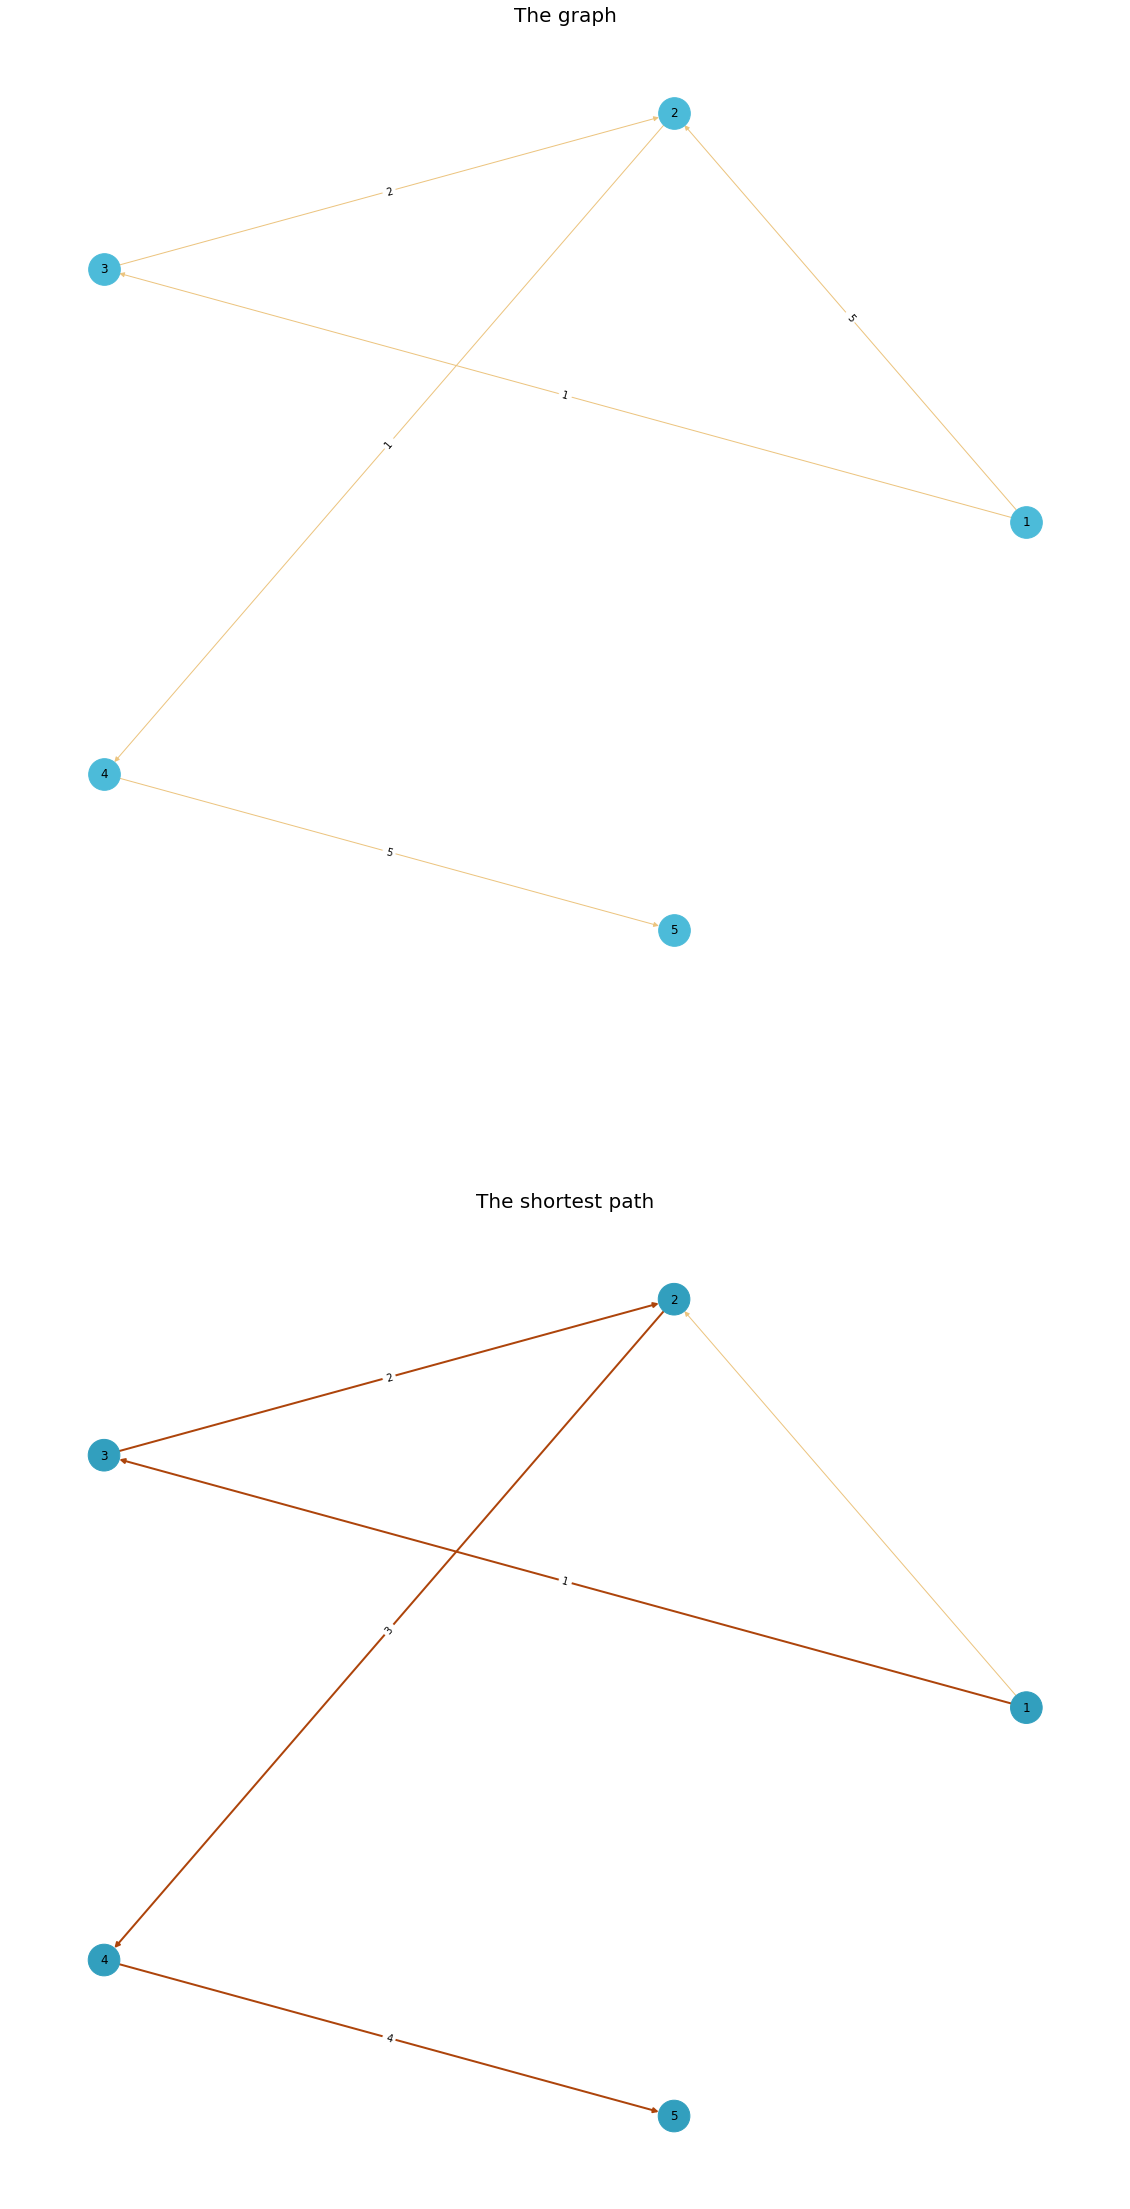

In [46]:
### The graph will be stored in this dictionary
MyGraph = defaultdict(lambda: defaultdict(int))

# Taking the edges from the user
print('Give me the edges and its weight here \'source destination weight\' !')
while True: 
    Edges = list(map(int, input('Give me the edges and the weights (put \'0 0 0\' to stop): ').split()))
    if Edges == [0, 0, 0]:
        break
    MyGraph[Edges[0]][Edges[1]] = Edges[-1]

# Taking the order of the nodes that should be seen 
Orders = list(map(int, input('Give me the order of the nodes that should be seen: ').split()))

# The source and destination 
Source, Destination = list(map(int, input('Give me the source and destination: ').split()))

Route = Check_path_existence(MyGraph, Orders, Source, Destination)
Show_graph_and_shortest_path(MyGraph, Route[1])

Here you can give a test to the function. You can here add your own nodes and edges and then test the result of the function. 

## 2.4 __Functionality 4__ - Disconnecting graphs 
   
It takes in input:
 
 - Two different intervals of time (disjoint or not), which will lead to two different graphs, _G\_1_ (associated to interval 1) and _G\_2_ (associated to interval 2) 
 - Two users which are unique to each interval of time (_user\_1_ only appears in interval 1, while _user\_2_ only appears in interval 2)
 

The function should return the minimum number of links (considering their weights) required to disconnect the two graphs.

To perform the task we use the mincut s-t problem in particular using the Ford-Fulkerson Algorithm (source of the pseudocode: https://brilliant.org/wiki/ford-fulkerson-algorithm/).

```
def Ford-Fulkerson Algorithm (Graph GG, source s, sink t):
flow = 0
for each edge (u, v) in G:
    flow(u, v) = 0
while there is a path, p, from s -> t in residual network G_f:
    residual_capacity(p) = min(residual_capacity(u, v) : for (u, v) in p)
    flow = flow + residual_capacity(p)
    for each edge (u, v) in p:
        if (u, v) is a forward edge:
            flow(u, v) = flow(u, v) + residual_capacity(p)
        else:
            flow(u, v) = flow(u, v) - residual_capacity(p)
return flow
```
Also to have a visualition of the algorithm using a simple graph and undestand how to compute the algorithm I saw this video: https://www.youtube.com/watch?v=Tl90tNtKvxs.

In more direct way the algorithm modify the weight of the graph based on the path and the flow. At the end there will be a visiting to all the node beginning from user1 and the number of edge with 0 weight corrisponding to succesfull visited node will be the number of minimum cut.

To perform this we will construct:
* BFS (findAugmentingPath): to search a path from user1 to user2
* Stack + DFS: to visit all the node at the end
* The function pathFlow, that return the minimum weight to be subtract from the path in the graph
* The function Ford_Fulkerson that store the complete algorithm 

Now the task is to disconnect two user that are stored in two different graph, to perform this I will union the two different graph and perform the algorithm above.

### 2.4.1 Implementation of Stack 

In [16]:
# DEFINE the class STACK to perform the DFS traversal.
# We use a double ended que to better implement the stack
# also deque has the function to directily create the stack.
# We implement only the function needed for DFS.
class Stack:
  
    def __init__(self):
    # the initializer for the stack
        self.stack = deque()

    def push(self, data):
    # the fucntion push to add element
    # to the stack
        self.stack.append(data)  

    def pop(self):
    # pop item from the stack 
    # if the stack is empty we need
    # to return None 
        if len(self.stack):
            return self.stack.pop() 
        else:
            return None

    def isEmpty(self):
    # function to check if the Stack is empty
        if len(self.stack) == 0:
            return True
        else:
            return False

### 2.4.2 Implementation of DFS

In [17]:
# Function DFS: Deapth-First-Search
# input: graph
#        s <- the star node of the search
def DFS(graph, s):

    # initialize stack
    stack = Stack()
    # initialize dictionary of 
    # marked node
    visited = dict()

    # marke the first node
    stack.push(s)
    visited[s] = True
    
    # loop until the stack is empty 
    while not stack.isEmpty():
        v = stack.pop()
        # loop over the neighbors of v
        for u in graph[v].keys():
        # if we don't visited the node AND the 
        # weight in the graph is still stricly positive
        # (we need this modification for MaxFlow-MinCut)
        if not visited.get(u) and graph[v][u] > 0:
              visited[u] = True
            stack.push(u)

    # I need to return the dict of visited node
    return visited

### 2.4.3 findAugmentingPath function 

In [18]:
# input>> - graph:  graph
#         - s:      satarting node
#         - t:      ending node

# We will implement this function like a **BFS**
# we want to search a path from s to t
def findAugmentingPath(Rgraph, s, t):

    # initialize the queue
    q = Queue()
    # initialize the marker of visited nodes
    # and the parent node
    visited = dict()
    parent = dict()
    # start: mark the first node as visited and enque
    visited[s] = True
    parent[s] = -1
    q.put(s)

    # loop until the q is empty
    while not q.empty():
        v = q.get()
        # loop over the neighbors
        for u in Rgraph[v].keys():
          # if we don't see that node OR there are still flow
          if not visited.get(u) and Rgraph[v][u] > 0:
            # update
            visited[u] = True
            parent[u] = v
            q.put(u)

  # return the path stored in parent
    return parent if visited.get(t) else False

### 2.4.4 pathFlow function

FlowPath: smallest weight in the path from user1 to user2.

To find the FlowPath I get travel back the dictionary of parent starting from user2 going to user1 and compute the minimum of previous FlowPath and the current weight of the traversal.

In [19]:
# input: Rgraph << the residual graph
#        path << the path from user1 to user2
#        user1,user2 << the node to be disconnected
def pathFlow(Rgraph, path, user1, user2):
    # initialize FlowPath to a big number
    FlowPath = 10**4
    # tmp for user2
    child = user2
    # loop while I don't traverse back to sourch node user1
    while child != user1:
        # get the parent 
        parent = path[child]
        # store the minimum 
        FlowPath = np.minimum(FlowPath, Rgraph[parent][child])
        # move to next node updating the child
        child = path[child]
  
    return FlowPath

### 2.4.5 Ford_Fulkerson function 

In [20]:
def Ford_Fulkerson(graph, user1, user2):
    # initialize flow
    Flow = 0
    # create a copy of my graph that needs to be modify
    # and don't point to my original graph
    Rgraph = copy.deepcopy(graph)
    # search first path
    path = findAugmentingPath(Rgraph, user1, user2)
    # loop while I found path
    while path:
        # search the minimum flow in the path
        FlowPath = pathFlow(Rgraph, path, user1, user2) 
        # update the weight along the path
        # traversing back from the end (user2) to start (user1)
        # of the path
        child = user2
        while child != user1:
          # get the parent node
          parent = path[child]
          # substracting the flow
          Rgraph[parent][child] -= FlowPath
          # move to next node updating the child
          child = path[child]
        # update the Overall Flow of the node
        Flow += FlowPath
        # find new path and return to the loop
        path = findAugmentingPath(Rgraph, user1, user2)
  
  return Rgraph, Flow

### 2.4.6 unionGraph function

In [21]:
def unionGraph(G1,G2):
    # start from G1, "append" G2
    # updating the edge and key with their value
    G = copy.deepcopy(G1)

    for key in G2.keys():
        if G.get(key):
            G[key] = Counter(G[key])+Counter(G2[key])
        else:
            G[key] = G2[key]

    return G

### Functionality 4 (Main Function)

In [22]:
def Functionality4(dataset, timeA, timeB, timeA2, timeB2, user1, user2):
    # get the two graph defined by the timestamp
    G1 = Build_graph(dataset, timeA, timeB )
    G2 = Build_graph(dataset, timeA2, timeB2 )

    # unify the graph
    G = unionGraph(G1,G2)
    # get the residual graph (with the 0 weight)
    # and return also the flow for checking pourpose
    RG, flow = Ford_Fulkerson(G, user1, user2)
  
    # visit the residual graph and return the dict of 
    # marked node 
    visited = DFS(RG, user1)
    # search in the original graph the edge with the 
    # characteristic we want and save the number of mincut
    # and the edge cutted itself
    mincut = 0
    cutUsers = []
    for node in G.keys():
        for edge in list(G[node]):
            if RG[node][edge] == 0 and G[node][edge] > 0 and visited.get(node):
                mincut += 1
                cutUsers.append((node,edge))
  
  return mincut, cutUsers

# 3. Implementation of the frontend

## 3.1 __Visualization 1__
 
Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input. 

To achieve this task I need to create some other and more specific functions. For example if I need to plot the Degree distribution of the graph (in particolar our directed graph) I need to return the distribution of the In-degree and Out-Degree so I will create a function to found this degree and also the sum of thise that define the "overall" degree of a node.

In [24]:
def countDegree(graph):
  # create a dict: {nodes: outdegree}
  # create a dict: {nodes: indegree}
  # final:         {nodes: degree = out+in}

    # initialize the set of users
    users = set()
    # loop over the (node, neighbors) of the graph
    for tail, neighbors in graph.items():
        # add the elements
        users.add(tail)  
        users.update(neighbors)
  
    # define the dict Out-degree of the node
    # key: users, value: the corrisponding out-degree
    outdegree = dict.fromkeys(users, 0)
    # compute outdegree storing the length of the 
    # neighbors of a node (in our stored graph are the head)
    for node in graph.keys():
        outdegree[node] = len(graph[node].keys())

    # define the dict Out-degree of the node
    # key: users, value: the corrisponding in-degree
    indegree = dict.fromkeys(users, 0)
    # compute indegree founding many time a node is 
    # pointed by another node in the graph
    for neighbors in graph.values():
        for node in neighbors:
            indegree[node] += 1

    # compute the overall degree of a node: in+out
    degree = dict.fromkeys(users, 0)
    for node in degree.keys():
        degree[node] = outdegree[node] + indegree[node]

    return degree, indegree, outdegree

In [25]:
def degree_transform(degreeDict, totalUsers):
    # count the frequency of the degree of the nodes
    frequency = Counter(degreeDict.values())
  
    # separate the dictionary: 
    # keys (nLink) are the degree, values (frequence_norm) is the counter
    nLink = list(frequency.keys())
    frequence_norm = np.array([float(frequency[k]) for k in nLink])/totalUsers

    return nLink, frequence_norm

In [26]:
# function to compute the plot
def plot_degree(nIn, FreqIn, nOut, FreqOut, nAll, FreqAll):
    fig, ax = plt.subplots(1,2, figsize = (15,8))

    ax[0].plot(nIn, FreqIn, 'go', label='in-degree') 
    ax[0].plot(nOut, FreqOut, 'bo', label='out-degree')
    ax[0].set_xlabel('Degree')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].legend()

    ax[1].plot(nAll, FreqAll, 'ro', label='degree = In + Out') 
    ax[1].set_xlabel('Degree')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].legend()
    plt.show()

Visualize the Answers to questions dataset.

In [27]:
# create the graph using the dataset and all the time in it
Ga2q = Build_graph(a2q)

In [28]:
# return the information needed to be plotted
directed, n_users, n_edges, average_link4users, density, dense = Functionality1(Ga2q)

headers = ['Dataset','Directed', 'Number of Users', 'Number of Edges', 'Average Link for Users', 'Density degree','Dense']
information = ['Answer2questions',directed, n_users, n_edges, average_link4users, density, dense]

table = [headers, information]

In [29]:
# creating the dictionary of the degree distribution
degree_dict, indegree_dict, outdegree_dict = countDegree(Ga2q)

nOut, FreqOut = degree_transform(outdegree_dict, n_users)
nIn, FreqIn = degree_transform(indegree_dict, n_users)
nAll, FreqAll = degree_transform(degree_dict, n_users)

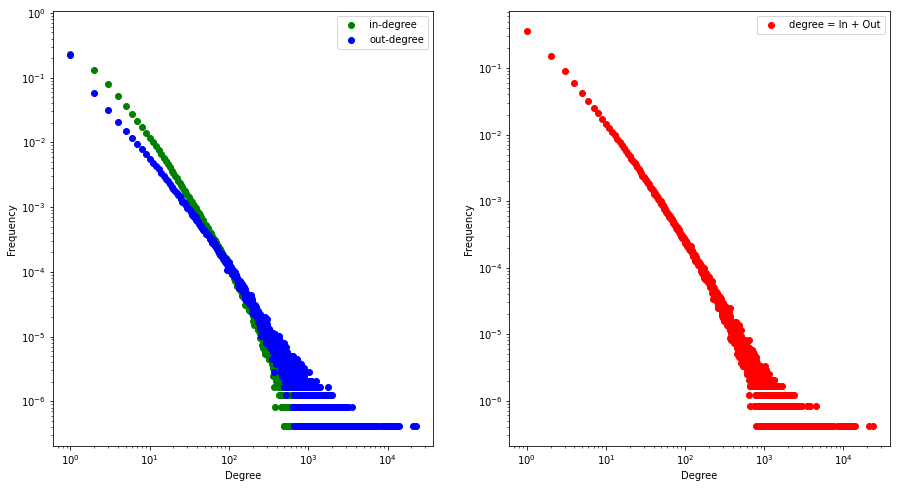

In [30]:
plot_degree(nIn, FreqIn, nOut, FreqOut, nAll, FreqAll)

In [31]:
print(tabulate(table, headers = 'firstrow', tablefmt='fancy_grid'))

╒══════════════════╤════════════╤═══════════════════╤═══════════════════╤══════════════════════════╤══════════════════╤═════════╕
│ Dataset          │ Directed   │   Number of Users │   Number of Edges │   Average Link for Users │   Density degree │ Dense   │
╞══════════════════╪════════════╪═══════════════════╪═══════════════════╪══════════════════════════╪══════════════════╪═════════╡
│ Answer2questions │ True       │           2433067 │          15801794 │                        6 │      2.66931e-06 │ False   │
╘══════════════════╧════════════╧═══════════════════╧═══════════════════╧══════════════════════════╧══════════════════╧═════════╛


From the plot of the loglog degree distribution we can see that match perfectly the table above. 

For example looking at the degree distribution we have that the probability of having a degree between 1 and 10 is very high and reflect having an average link for users of 6. Also we can see that the graph is sparse, infact we have a huge connection (hub, with higher degree) with low probability and overall low connection with high probability.

I prefer to plot the degree distribution as a loglog plot because we have a very huge number of node in our graph and most of the node has a very low probability which result in a invisible histogram and that give no visible information about our dataset.

## 3.2 __Visualization 2__

* **You can see the output of the betweeness**

Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): 2008-9-03-01
Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): 2008-9-03-05
Please give me the name of the user: 184


Please enter the number if the metric you want: 
1. Betweness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
Your choice: 1
------------------------------


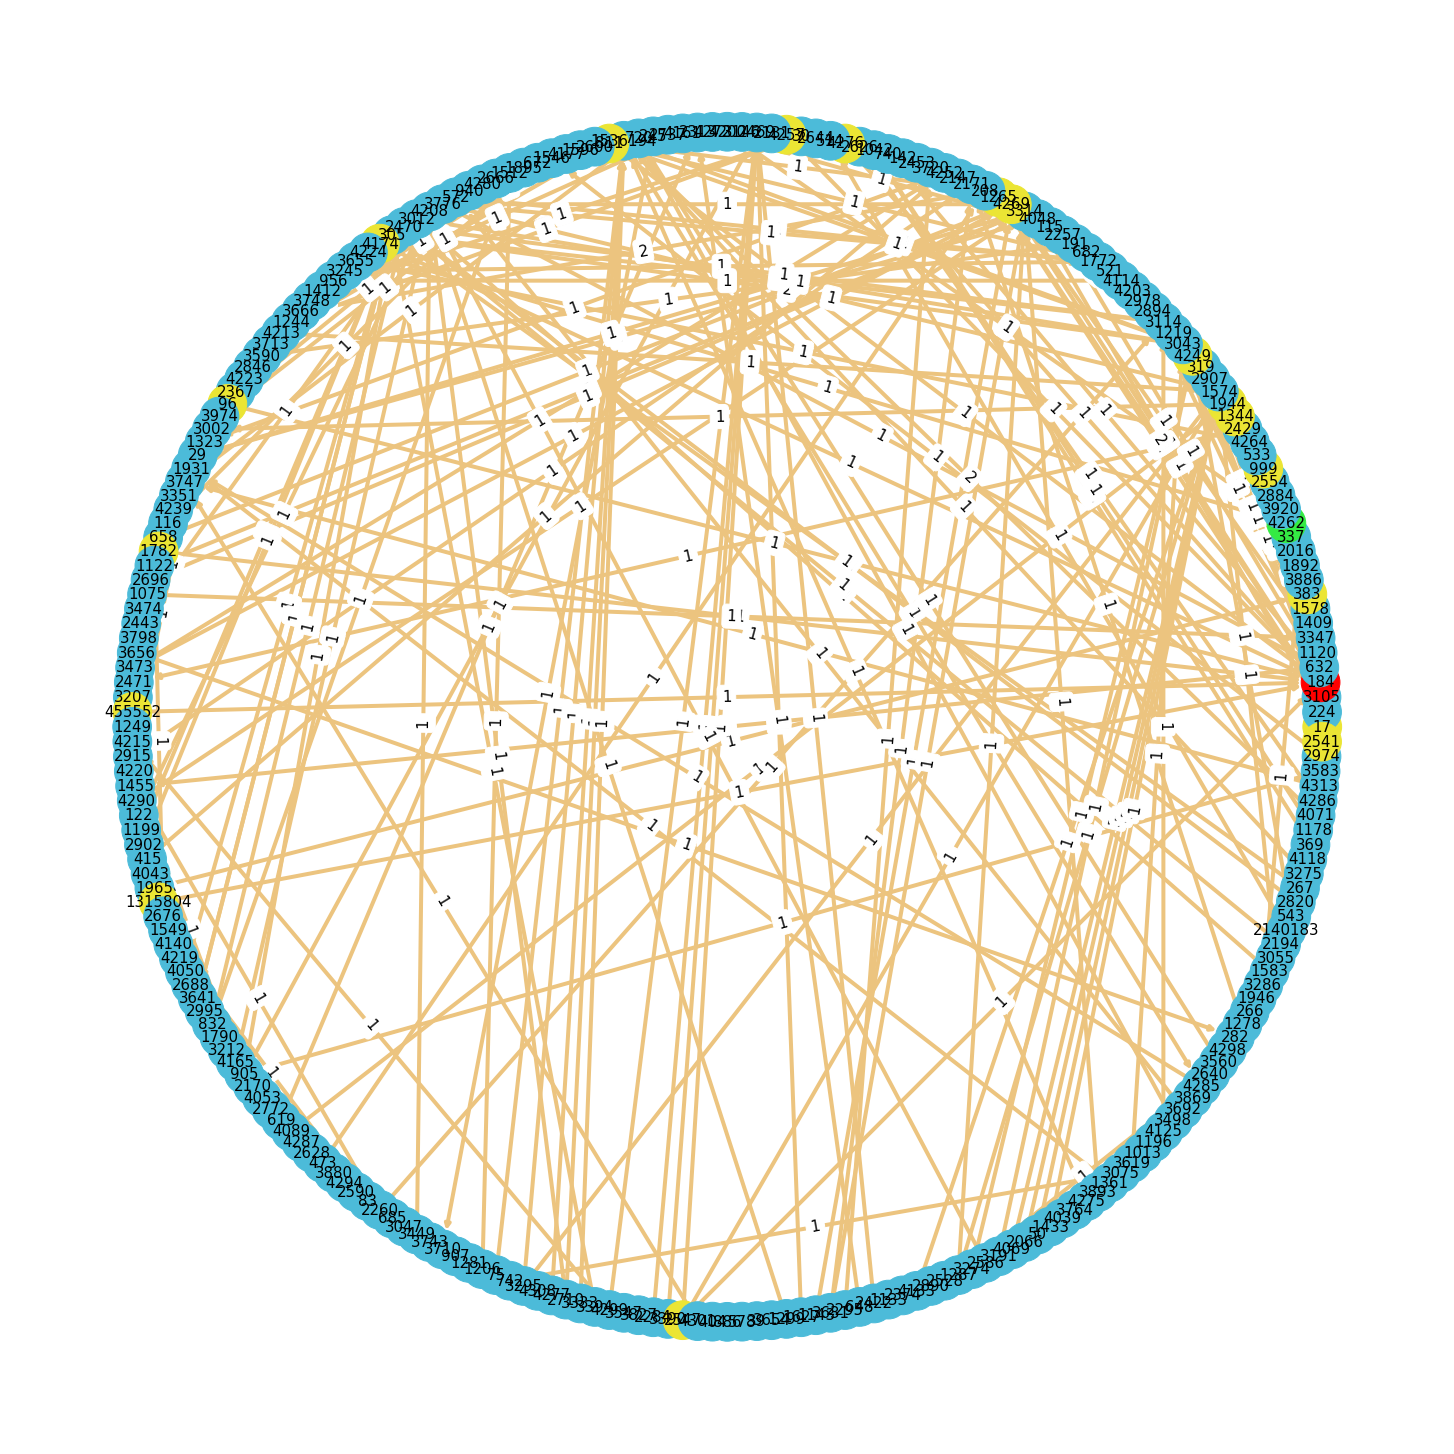


---You can see the incoming edges in 'yellow' and the node itself in 'red ' and the outgoing edges in 'green'.
This is the value of the betweness centrality of the user 184:  40.0


In [79]:
Begin_date = input('Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): ')
End_date  = input('Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): ')
User = int(input('Please give me the name of the user: '))
print('\n\nPlease enter the number if the metric you want: \n1. Betweness\n2. PageRank\n3. ClosenessCentrality\n4. DegreeCentrality')
Metric = int(input('Your choice: '))
print('-' * 30)

Func2(Begin_date, End_date, User, Metric)

* **You can see the output of PageRank**

Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): 2008-9-03-01
Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): 2008-9-03-08
Please give me the name of the user: 383


Please enter the number if the metric you want: 
1. Betweness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
Your choice: 2
------------------------------
The page rank of the node '383' is:  0.004862051204637086
The maximum of the page rank is '0.006655754583674123' is:  184


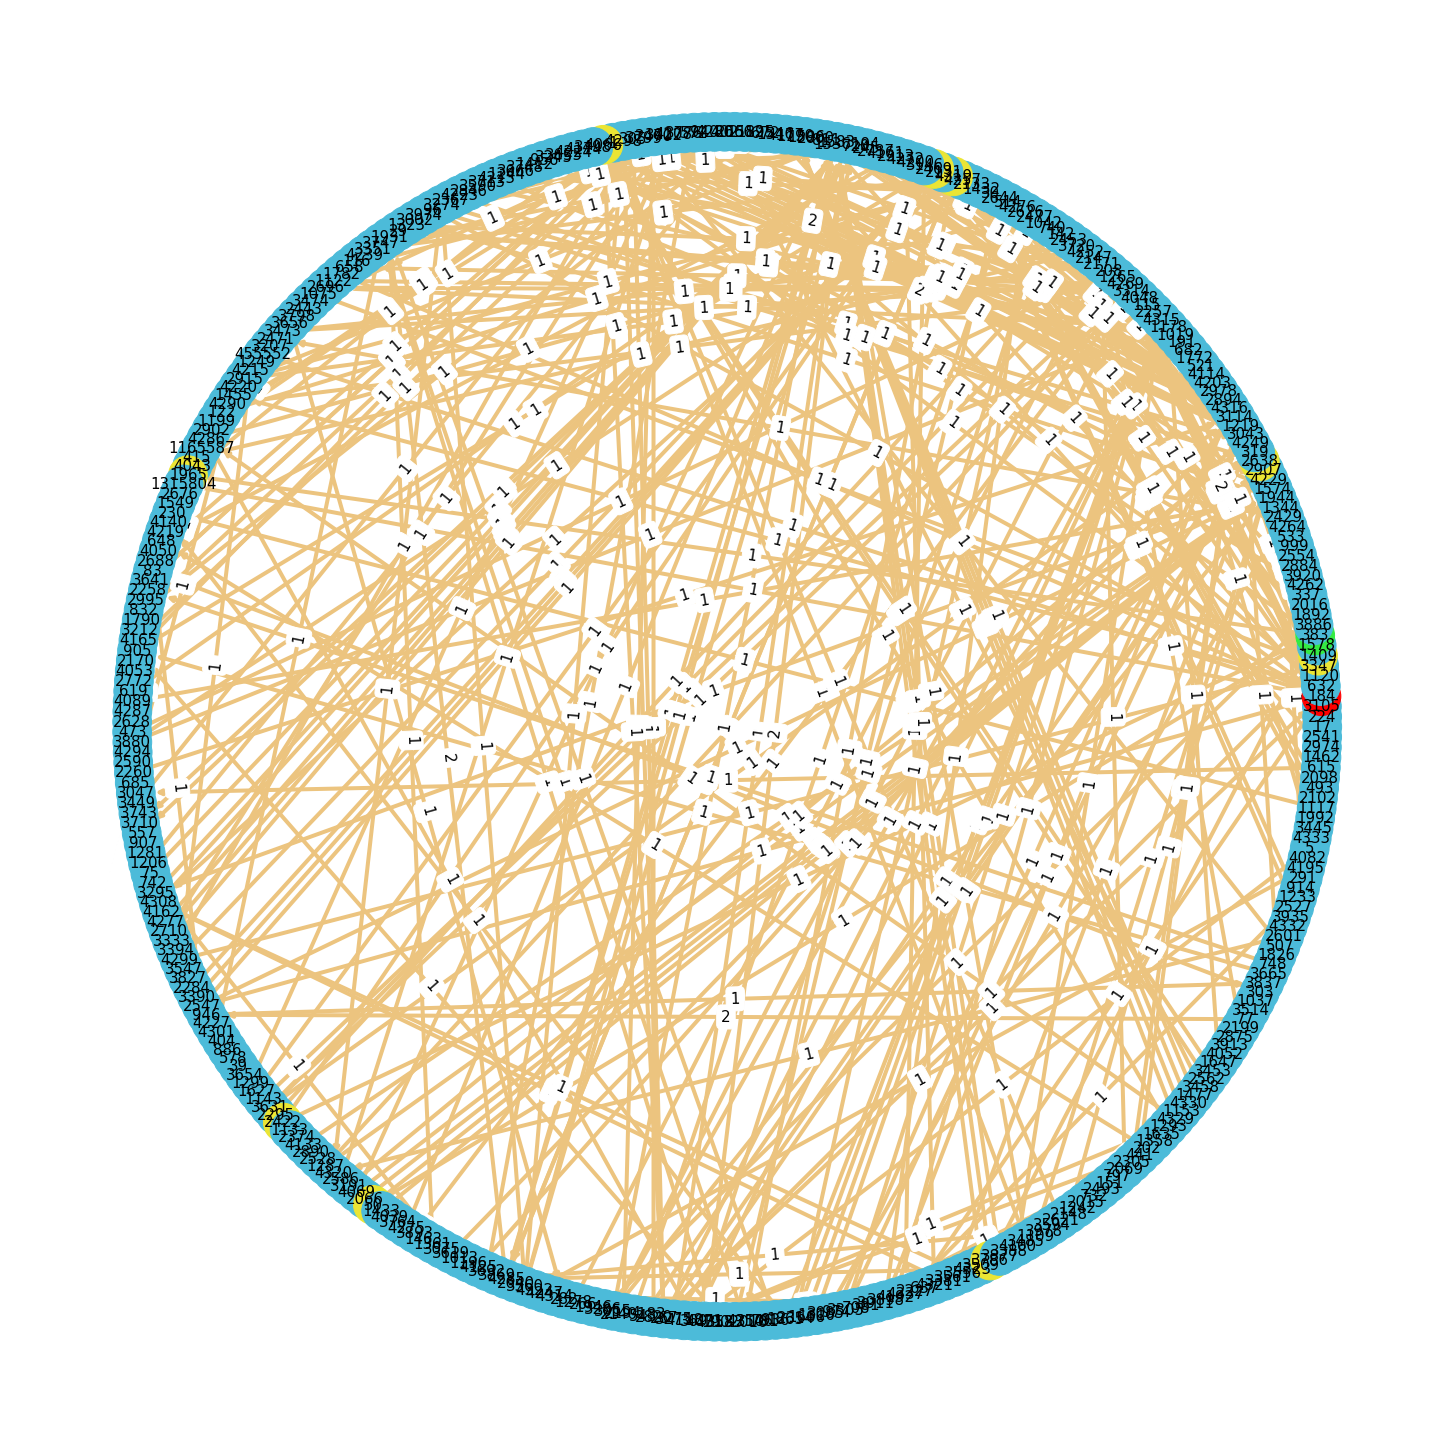


---You can see the incoming edges in 'yellow' and the node itself in 'green/red' and the node that has the maximum PageRank in 'red'.


In [82]:
Begin_date = input('Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): ')
End_date  = input('Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): ')
User = int(input('Please give me the name of the user: '))
print('\n\nPlease enter the number if the metric you want: \n1. Betweness\n2. PageRank\n3. ClosenessCentrality\n4. DegreeCentrality')
Metric = int(input('Your choice: '))
print('-' * 30)

Func2(Begin_date, End_date, User, Metric)

* **You can see the output of the Closeness Centrality**

Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): 2008-9-03-00
Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): 2008-9-03-05
Please give me the name of the user: 572


Please enter the number if the metric you want: 
1. Betweness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
Your choice: 3
------------------------------


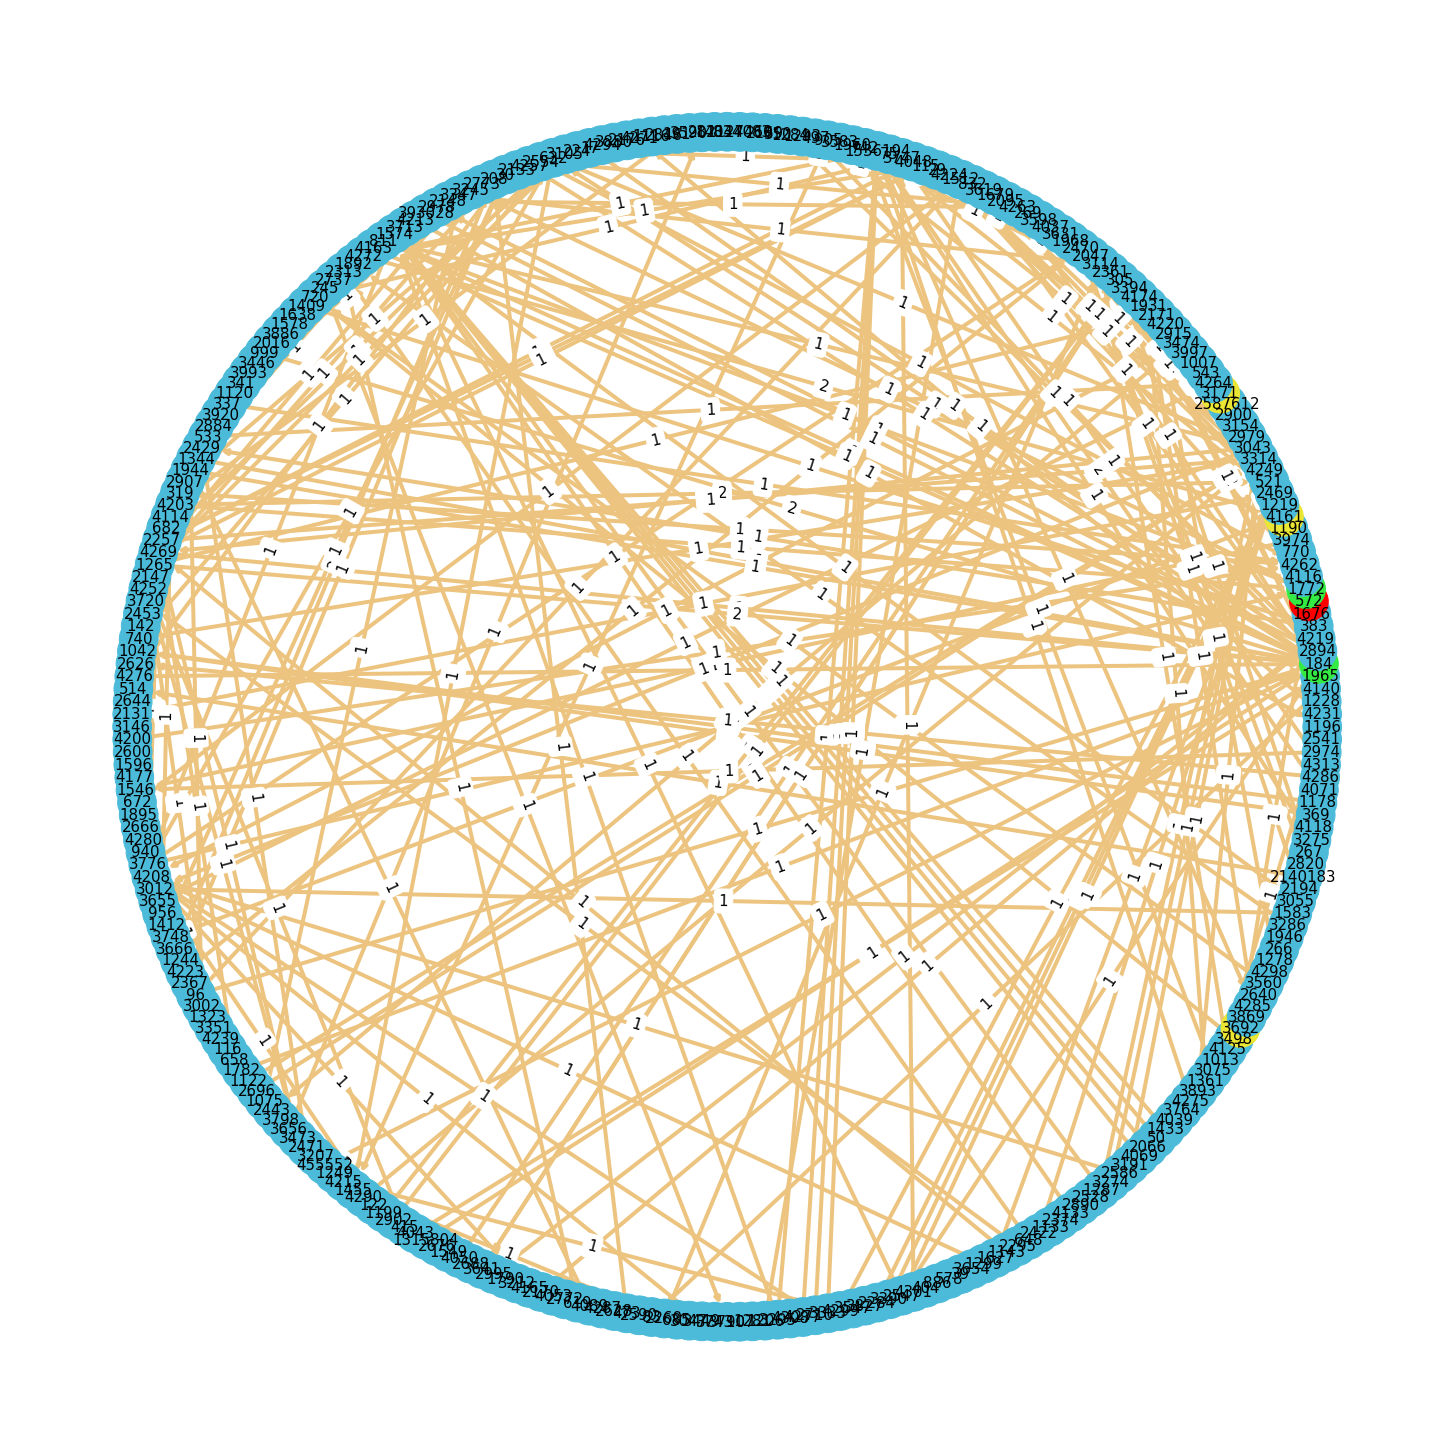


---You can see the incoming edges in 'yellow' and the node itself in 'red ' and the outgoing edges in 'green'.
This is the value of the Closeness Centrality of the user 572:  3.2833333333333337


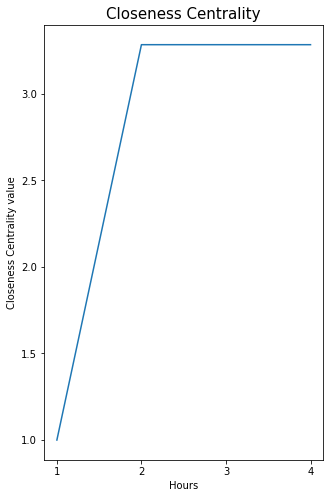

In [83]:
Begin_date = input('Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): ')
End_date  = input('Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): ')
User = int(input('Please give me the name of the user: '))
print('\n\nPlease enter the number if the metric you want: \n1. Betweness\n2. PageRank\n3. ClosenessCentrality\n4. DegreeCentrality')
Metric = int(input('Your choice: '))
print('-' * 30)

Func2(Begin_date, End_date, User, Metric)

* **You can see the output of Degree Centrality**

Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): 2008-9-03-0
Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): 2008-9-03-05
Please give me the name of the user: 383


Please enter the number if the metric you want: 
1. Betweness
2. PageRank
3. ClosenessCentrality
4. DegreeCentrality
Your choice: 4
------------------------------


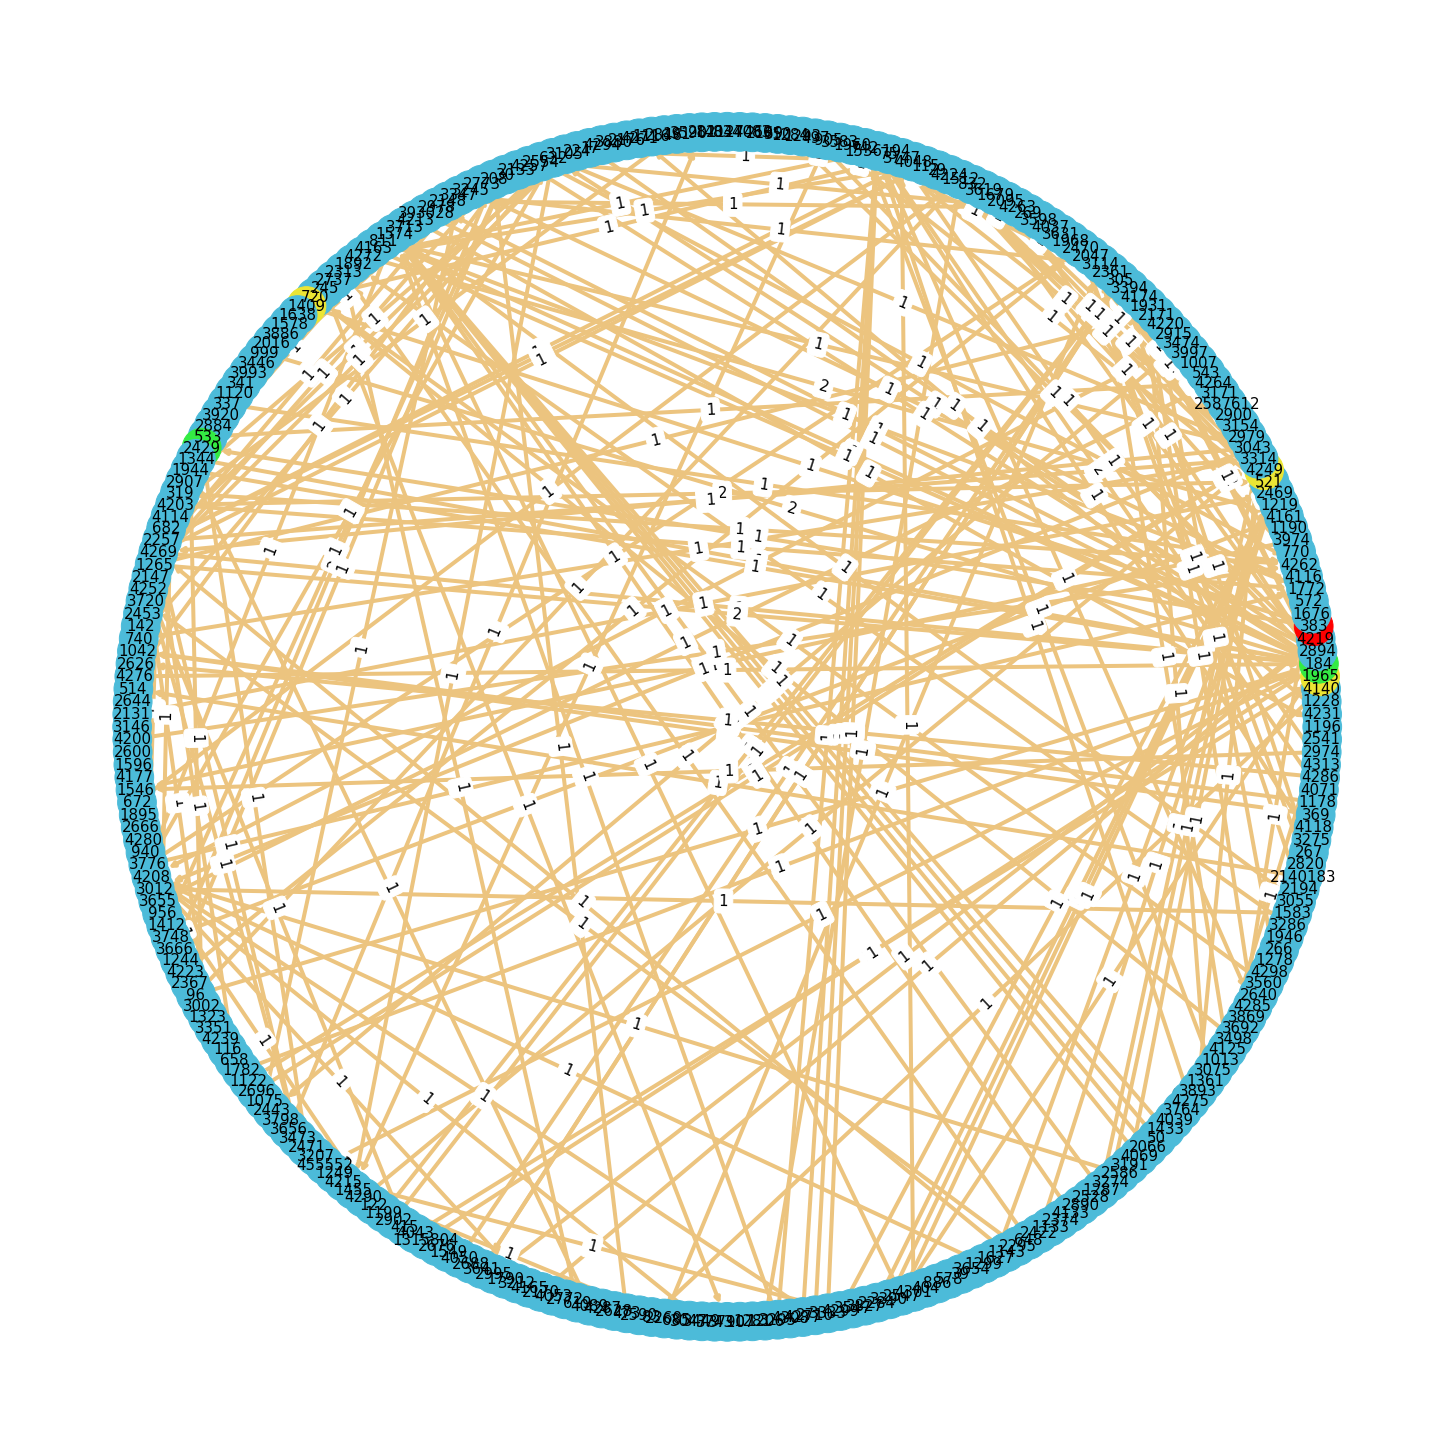


---You can see the incoming edges in 'yellow' and the node itself in 'red ' and the outgoing edges in 'green'.
The degrees of the user 383 are:

 1. in-bound = 0.010135135135135136,
 2. out-bound = 0.006756756756756757


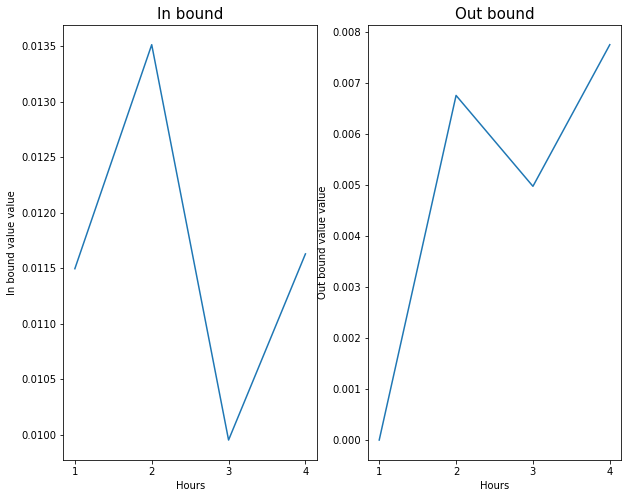

In [88]:
Begin_date = input('Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): ')
End_date  = input('Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): ')
User = int(input('Please give me the name of the user: '))
print('\n\nPlease enter the number if the metric you want: \n1. Betweness\n2. PageRank\n3. ClosenessCentrality\n4. DegreeCentrality')
Metric = int(input('Your choice: '))
print('-' * 30)

Func2(Begin_date, End_date, User, Metric)

## 3.3 __Visualization 3__

Here the user can give an interval with begin date and end date, and we will show him the graph for that interval. 

Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): 2008-09-02-00
Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): 2008-09-02-01


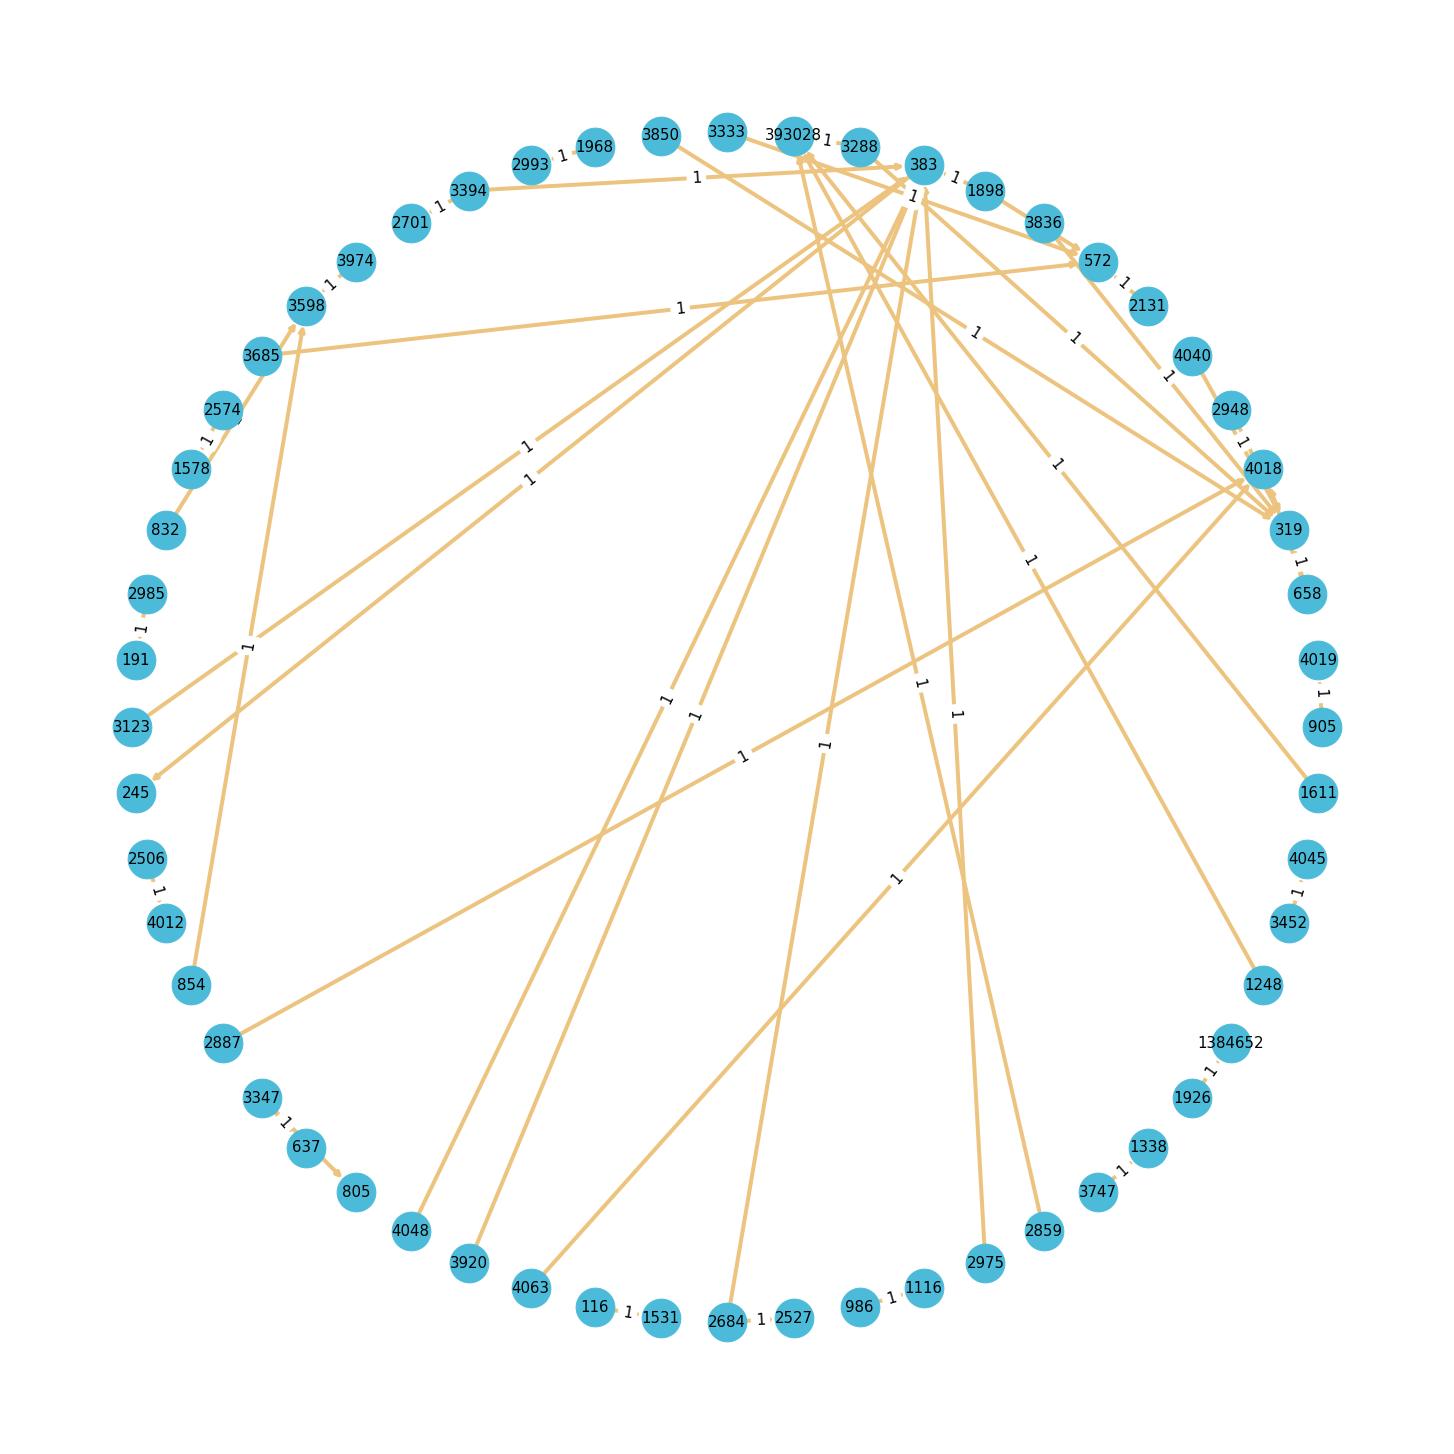

In [15]:
Begin_date = input('Pleae give me the begin date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-9-03-01): ')
End_date  = input('Pleae give me the end date of the interval (YEAR-MONTH-DAY-HOUR, ex: 2008-09-03-02): ')
TempGraph = Build_graph(Merged_df, Begin_date, End_date )
Show_graph(TempGraph)

 Now after seeing the graph, user can give us the source, destination and the order of the nodes that should be visited. 

Please enter the source node: 3123
Please enter the destination node: 245
Please give me the order of the nodes that should be visited (ex. 1 2 3 )
True


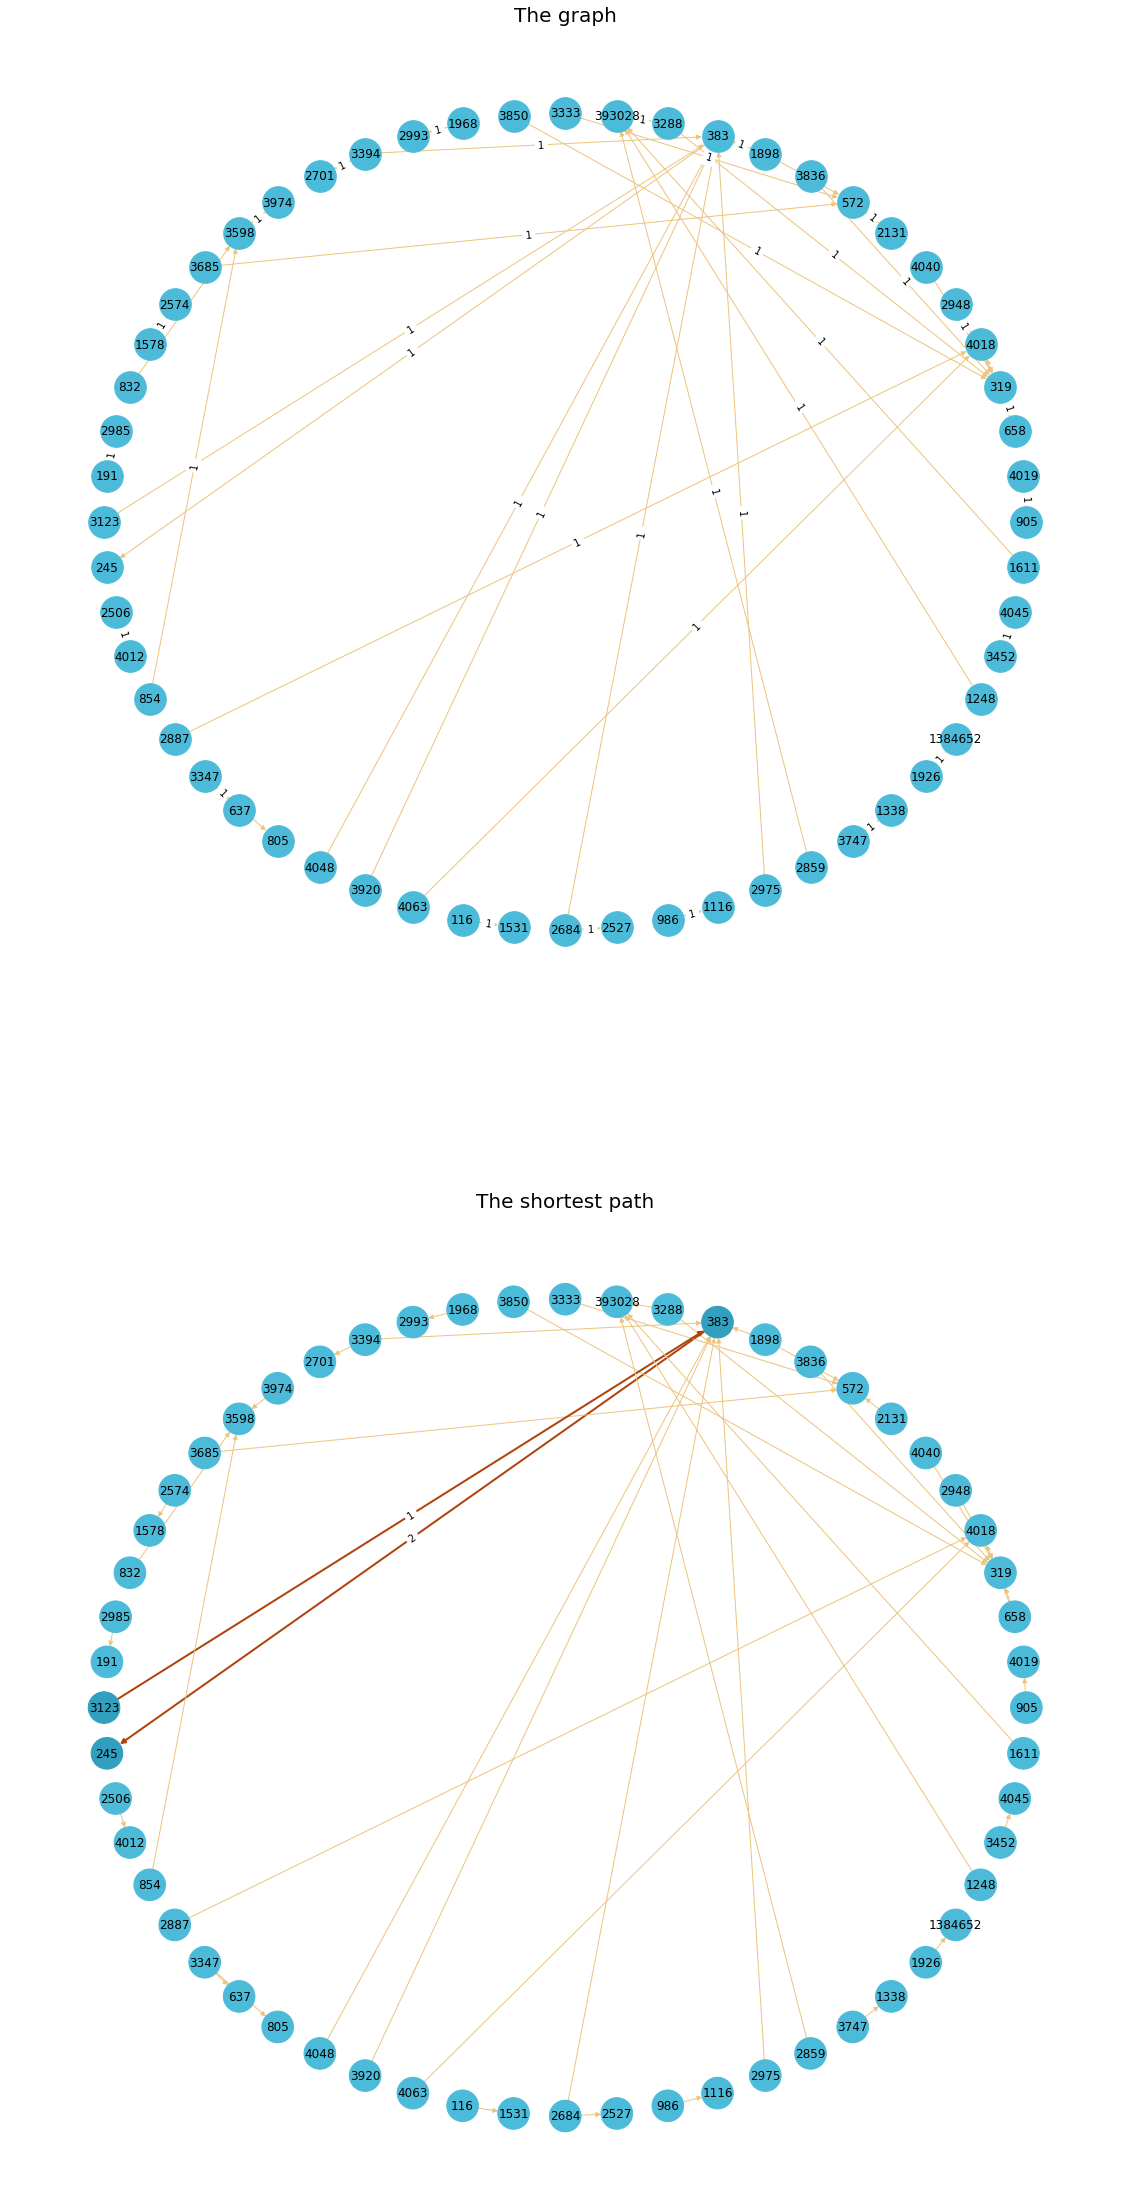

In [34]:
Source = int(input('Please enter the source node: '))
Destination = int(input('Please enter the destination node: '))
Visiting_order = list(map(int , input('Please give me the order of the nodes that should be visited (ex. 1 2 3 )').split()))
Verdict, Answer = Check_path_existence(TempGraph, Visiting_order, Source, Destination)

if Verdict: 
    Show_graph_and_shortest_path(TempGraph, Answer)
else:
    print('Not possible to do this!!!')


## 3.4 __Visualization 4__
Show a visualization of the links needed to be removed in order to disconnect both graphs.

In [34]:
def users(graph):
    users = set()
    # loop over the (node, neighbors) of the graph
    for tail, neighbors in graph.items():
        # add the elements
        users.add(tail)  
        users.update(neighbors)

    return users

For visulize the cut in the graph to disconnet two node I choose to use a small amount of time that gives me few node but garantie two almost disconnected graph with lot of connection to perform and better view the algorithm. 

In [35]:
# store the imput and the choosen time and users
timeA = '2008-8-1-12'
timeB = '2008-8-1-23'
timeA2 = '2008-8-2-1'
timeB2 = '2008-8-2-12'
user1 = 100
user2 = 32

In [36]:
# get the information needed to be plotted
mincut, edgesCut = Functionality4(Merged_df, timeA, timeB, timeA2, timeB2, user1, user2)   # get the thing to visualize

In [37]:
# create the graph needed for the plot
G1 = Build_graph(Merged_df, timeA, timeB )
G2 = Build_graph(Merged_df, timeA2, timeB2 )

# unify the two graph
G = unionGraph(G1,G2)

# choose only a specific subgraph only to zoom over the cut
subnode = [100,106,96,91,71,17,32,30,48,109,49,13,23,11,1,62,60,55,86,78,8,51]
Gdict = nx.DiGraph(G)
HH = Gdict.subgraph(subnode)
A = to_agraph(HH)

In [38]:
# modify the graph coloring the node and edge to
# visualize the plot and what we want.
for node in list(A):   # LOOP over the USERS (HEAD + TAIL) of G
    n = A.get_node(node)
    if int(node) in list(users(G1)) and node in list(users(G2)):
        n.attr["color"] = "cyan:hotpink"
        n.attr['style'] = 'filled'
    elif int(node) in list(users(G2)):
        n.attr["color"] = "hotpink"
        n.attr['style'] = 'filled'
    elif int(node) in list(users(G1)):
        n.attr["color"] = "cyan"
        n.attr['style'] = 'filled'

In [39]:
# color the users START END
n = A.get_node(user2)
n.attr["color"] = "cyan:green"
n.attr['style'] = 'filled'
n = A.get_node(user1)
n.attr["color"] = "hotpink:red"
n.attr['style'] = 'filled'

path_1 = [(100,106),(106,96),(96,91),(17,32)]
path_2 = [(100,106),(106,71),(71,91),(17,32)]
path_3 = [(100,91),(91,71),(71,91),(17,32)]

ALLedge = list(path_1 + path_2 + path_3)
for edge in ALLedge:
    if edge in path_1 and edge in path_2 and edge in path_3:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "green:coral:blue"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"
    elif edge in path_1 and edge in path_2:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "green:coral"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"
    elif edge in path_1 and edge in path_3:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "green:blue"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"
    elif edge in path_2 and edge in path_3:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "coral:blue"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"
    elif edge in path_1:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "green"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"
    elif edge in path_2:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "coral"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"
    elif edge in path_3:
        e = A.get_edge(edge[0], edge[1])
        e.attr["color"] = "blue"
        e.attr['penwidth'] = 2
        e.attr['label'] = str(G[edge[0]][edge[1]])
        e.attr['fontsize'] = 30
        e.attr['fontname'] = 'Helvetica'
        e.attr['style'] = 'solid'
        e.attr['fontcolor'] = "black"


# color the edge
for edge in edgesCut:
    e = A.get_edge(edge[0], edge[1])
    e.attr["color"] = "crimson"
    e.attr['style'] = 'dashed'
    e.attr['penwidth'] = 6
    e.attr['label'] = str(G[edge[0]][edge[1]])
    e.attr['fontsize'] = 30
    e.attr['fontcolor'] = "crimson"
    e.attr['fontname'] = 'Helvetica'


In [40]:
A.layout('dot')
A.draw('Final_plot.png')

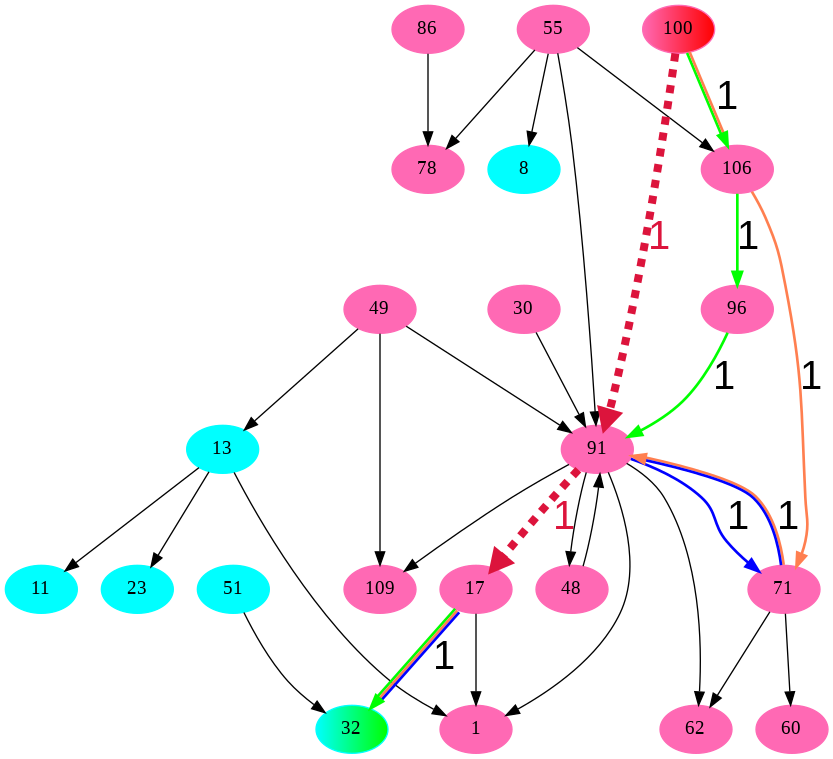

In [41]:
Image(filename='Final_plot.png') 

As we can see in the image we have two different graph: the cyan and the pink one. The users1 (100) and users2 (32) are from two different graph and I choose to color the node with green or red and the color of the graph they belogs to. The choose of store "not usefull" node is to have an idea on how the two graph have different node but somehow connected from each other.

We can see how there are various path to reach node 32 from node 100 (visualized by using each path a different color) but disconnecting the two big dotted arrow we fully cut the other path using the minimum weight and edge.

# 4. Algorithmic question

A number **n** of kids are in a camp. Between some **k pairs** of them (a kid can be part of more than one pairs) there are often **fights**. At night there are **two dormitories** where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that **each pair of kids that fights often is assigned to a different dormitory**. (There are no space problems and the two dormitories can have different number of kids.)

Give an algorithm that is **linear in n and k** that is able to answer whether such an assignment is **possible** and, if so, return one.

1. Here we have an algorithm which goes **through the kids once**, and also **through the pairs once**.
2. In total we have just **scanned the provided information once**. 
3. Our implementaion uses **dictionary** and **sets** which are **really fast in accessing the data**. They will cost **O(1)**. 
4. In total we can consider the **time complexity of our algorithm as O(N+K)**. 

* **Note:** We know that we can't have such assignment when at least three kids are all in fight with each other. 
- In our algorithm we will check for such triple of kids that all of them are in fight. 

## 4.1 Check_formation function 

In this function checks, given **the number of the kids** and **the pairs of the kids that are in fight**, we can assign **each kid to a dorm without having at least one of his opponent in the same dorm or not.** 

The input and the output of the function: 
1. **_Inputs:_**<br/><br/>
    1. **N:** The number of the kids
    2. **Fight_pairs:** A list of pairs of the kids that are in fight with each other
<br/><br/>
2. **_Outputs:_** <br/><br/>
    Depend on what is the result of our check we have different outputs. 
    1. **If such assignment is possible:** 
        1. **True:** To indicate that we can have such assignment 
        2. **Opponent_of_kid:** A dictionary which will contain all the oponents of each kid
    2. **If such assignment is not possibe:** 
        1. **False:** To indicate that we can not have such assignment
        2. **Possible_problem:** A list contains three kids that are preventing us to have such assignemnt
   
   

In [27]:
def Check_formation(N, Fight_pairs):

    # We will store the opponent of each kid in a dictionary
    # Also we will assume in the beginning that such assignment is possibe
    Opponent_of_kid, Possible = defaultdict(set), True

    # We will go through each fight pair
    for Fight in Fight_pairs:

        # Check if these two kids have an opponent shared
        Possible_problem = Opponent_of_kid[Fight[0]].intersection(Opponent_of_kid[Fight[1]])

        # If we could find another kid which is in fight with both of these kids
        if Possible_problem:

            # We know that we can not distribute them between two dorms 
            # as each of them will share a dorm with one of his opponents
            Possible = False

            # So we store that these people are all in fight
            Possible_problem.update(Fight)

            # As we found a problem here, there is no need to go through other pairs
            break

        # If so far we were able to to distribute them between two dorm
        # We will add each of them to their opponent list
        Opponent_of_kid[Fight[0]].add(Fight[1])
        Opponent_of_kid[Fight[1]].add(Fight[0])
    
    # If it was possibe to have such assignment, we will return the opponents of each kid
    # otherwise we will return the kids that are making a problem for us 
    return (True, Opponent_of_kid) if Possible else (False, Possible_problem)

## 4.2 Formation function

In this function we will show the user what will be the result in each situation. 

The input and the output of the function: 
1. **_Inputs:_**<br/><br/>
    1. **Possibility:** To indicate whether such assignment is possible or not. 
    2. **Result:** Depend on the possibility of such assignment, it can contain different information: 
        1. **Possibility == True:** A dictionary which contains all the oponents of each kid
        2. **Possibility == False:** A list contains three kids that are preventing us to have such assignment. 
<br/><br/>
2. **_Outputs_:**<br/><br/> Depend on the possibility of such assignment, the function can have different outputs: 
    1. **Possibility == True:** Shows the kids that have been assigned to each dorm
    2. **Possibility == False:** Shows at least one of three kids that are preventing us to have such assignment. 
   

In [33]:
# In this function we will tell the user if we can have such assignment or no. 
def Formation(Possibility, Result):
        
    # If possible to do the assignment process without any fight
    if Possibility:
            
        # Tell the user that we can do this assignment
        print('\nYes we can do this assignment!!!')

        # To store the kids in each of the dorms
        First_dorm, Second_dorm = set(), set()

        # Here we will assign each kid a dorm 
        for kid in range(1, N + 1):

            # If the current kid was assigned to the first dorm
            if kid in First_dorm:

                # So his opponenets should be assigned to the second dorm
                Second_dorm.update(Result[kid])

            # If this kid was not in the first dorm
            else:

                # We will assign him the second dorm
                Second_dorm.add(kid)

                # Also we will assign his opponents to the first dorm
                First_dorm.update(Result[kid])

        # We show the user the formation 
        print('Kids in the first dorm are: ', First_dorm)
        print('Kids in the second dorm are: ', Second_dorm)

    # If we can not have such assignment
    else:

        # We tell the user that we can not have that assignment
        print('\nNo we can not do this assignment!!!')

        # We tell the user which kids are all in fight that prevent us to do such assignment
        print('At least one problem because these kids are all in fight: ', Result)

In [36]:
# Take the number of the kids, and also the number of pair fights
N, N_fight_pairs = int(input('Give me the number of kids: ')), int(input("Give me the number of fight pairs: "))

# We will store each fight pair here
Fight_pairs = []

# Here we will get all the pairs from the user
for i in range(N_fight_pairs):

    # We will get which kids are in fight
    Fight_pairs.append(tuple(map(int, input("Give me the pair \'"+str(i+1)+'\' :').split())))

# Show the result of our check
Formation(*Check_formation(N, Fight_pairs))


Give me the number of kids: 5
Give me the number of fight pairs: 4
Give me the pair '1' :1 5
Give me the pair '2' :2 3
Give me the pair '3' :3 1
Give me the pair '4' :4 1

Yes we can do this assignment!!!
Kids in the first dorm are:  {3, 4, 5}
Kids in the second dorm are:  {1, 2}
